In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import statsmodels.api as sm
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
from sklearn import metrics

In [2]:
df = pd.read_csv('SetBueno.csv')

In [3]:
df

,Unnamed: 0,index,date,Encoded Products,Cadereyta total $,Cadereyta ctdad,Coahuila total $,Coahuila ctdad,Durango total $,Durango ctdad,...,Queretaro total $,Queretaro ctdad,Reynosa total $,Reynosa ctdad,San Luis total $,San Luis ctdad,Total libre de impuestos,Ctdad Ordenada,Indefinido total $,Indefinido ctdad
0,0,4,2022-01-02,Producto 11,0.00,0.0,0.000,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,18162.13,3.5,58623.600,10.5,NaN,NaN
1,1,5,2022-01-02,Producto 6,0.00,0.0,0.000,0.0,0.0,0.0,...,23477.44,3.5,0.0,0.0,0.00,0.0,23477.440,3.5,NaN,NaN
2,2,6,2022-01-02,Producto 24,0.00,0.0,0.000,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.00,0.0,31083.500,3.5,NaN,NaN
3,3,7,2022-01-02,Producto 15,0.00,0.0,0.000,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.00,0.0,42846.020,7.0,NaN,NaN
4,4,8,2022-01-02,Producto 9,0.00,0.0,27154.855,3.5,0.0,0.0,...,0.00,0.0,0.0,0.0,0.00,0.0,27154.855,3.5,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30560,30560,4317,2023-12-31,Producto 273,0.00,0.0,34740.090,3.5,0.0,0.0,...,0.00,0.0,0.0,0.0,0.00,0.0,60970.805,7.0,NaN,NaN
30561,30561,4318,2023-12-31,Producto 273,35273.21,3.5,0.000,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.00,0.0,35273.210,3.5,NaN,NaN
30562,30562,4319,2023-12-31,Producto 273,0.00,0.0,0.000,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.00,0.0,41274.205,3.5,NaN,NaN
30563,30563,4320,2023-12-31,Producto 273,0.00,0.0,0.000,0.0,0.0,0.0,...,15192.10,3.5,0.0,0.0,0.00,0.0,15192.100,3.5,NaN,NaN


In [4]:
df.columns

Index(['Unnamed: 0', 'index', 'date', 'Encoded Products', 'Cadereyta total $',
       'Cadereyta ctdad', 'Coahuila total $', 'Coahuila ctdad',
       'Durango total $', 'Durango ctdad', 'Expos F total $', 'Expos F ctdad',
       'Laredo total $', 'Laredo ctdad', 'Monterrey total $',
       'Monterrey ctdad', 'Online total $', 'Online ctdad',
       'Queretaro total $', 'Queretaro ctdad', 'Reynosa total $',
       'Reynosa ctdad', 'San Luis total $', 'San Luis ctdad',
       'Total libre de impuestos', 'Ctdad Ordenada', 'Indefinido total $',
       'Indefinido ctdad'],
      dtype='object')

In [5]:
# Lista de ciudades para las que deseas realizar el proceso
ciudades = ['Cadereyta', 'Coahuila', 'Durango', 'Expos F', 'Laredo', 'Monterrey', 'Online',
            'Queretaro', 'Reynosa', 'San Luis']

# Diccionario para mapear los nombres de las columnas antiguas a los nuevos nombres de columnas
nuevos_nombres = {
    'Cadereyta total $': 'total',
    'Cadereyta ctdad': 'ctdad',
    'Coahuila total $': 'total',
    'Coahuila ctdad': 'ctdad',
    'Durango total $': 'total',
    'Durango ctdad': 'ctdad',
    'Expos F total $': 'total',
    'Expos F ctdad': 'ctdad',
    'Laredo total $': 'total',
    'Laredo ctdad': 'ctdad',
    'Monterrey total $': 'total',
    'Monterrey ctdad': 'ctdad',
    'Online total $': 'total',
    'Online ctdad': 'ctdad',
    'Queretaro total $': 'total',
    'Queretaro ctdad': 'ctdad',
    'Reynosa total $': 'total',
    'Reynosa ctdad': 'ctdad',
    'San Luis total $': 'total',
    'San Luis ctdad': 'ctdad',
}

# Crear un diccionario para almacenar los DataFrames modificados para cada ciudad
dfs_por_ciudad = {}

# Iterar sobre cada ciudad y realizar las operaciones necesarias
for ciudad in ciudades:
    # Selecciona las columnas correspondientes a la ciudad actual
    df_ciudad = df[['Encoded Products', 'date', f'{ciudad} total $', f'{ciudad} ctdad']]
    
    # Cambiar el nombre de la columna 'Encoded Products' eliminando 'Producto' y convirtiéndola a entero
    df_ciudad['Encoded Products'] = df['Encoded Products'].str.replace('Producto', '').str.strip()
    df_ciudad['Encoded Products'] = df_ciudad['Encoded Products'].astype(int)
    
    # Agregar una columna 'Ciudad' con el nombre de la ciudad actual para todas las filas
    df_ciudad['Ciudad'] = ciudad
    
    # Cambiar el nombre de las columnas según el diccionario 'nuevos_nombres'
    df_ciudad = df_ciudad.rename(columns=nuevos_nombres)
    
    # Guardar el DataFrame modificado para la ciudad actual en el diccionario 'dfs_por_ciudad'
    dfs_por_ciudad[ciudad] = df_ciudad


C:\Users\jesus\AppData\Local\Temp\ipykernel_4568\3554873387.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ciudad['Encoded Products'] = df['Encoded Products'].str.replace('Producto', '').str.strip()
C:\Users\jesus\AppData\Local\Temp\ipykernel_4568\3554873387.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ciudad['Encoded Products'] = df_ciudad['Encoded Products'].astype(int)
C:\Users\jesus\AppData\Local\Temp\ipykernel_4568\3554873387.py:42: SettingWithCopyWarning: 
A value is trying to be s

In [6]:
df_final = pd.concat(dfs_por_ciudad.values(), ignore_index=True)

In [7]:
df_final

,Encoded Products,date,total,ctdad,Ciudad
0,11,2022-01-02,0.0,0.0,Cadereyta
1,6,2022-01-02,0.0,0.0,Cadereyta
2,24,2022-01-02,0.0,0.0,Cadereyta
3,15,2022-01-02,0.0,0.0,Cadereyta
4,9,2022-01-02,0.0,0.0,Cadereyta
...,...,...,...,...,...
305645,273,2023-12-31,0.0,0.0,San Luis
305646,273,2023-12-31,0.0,0.0,San Luis
305647,273,2023-12-31,0.0,0.0,San Luis
305648,273,2023-12-31,0.0,0.0,San Luis


# EDA

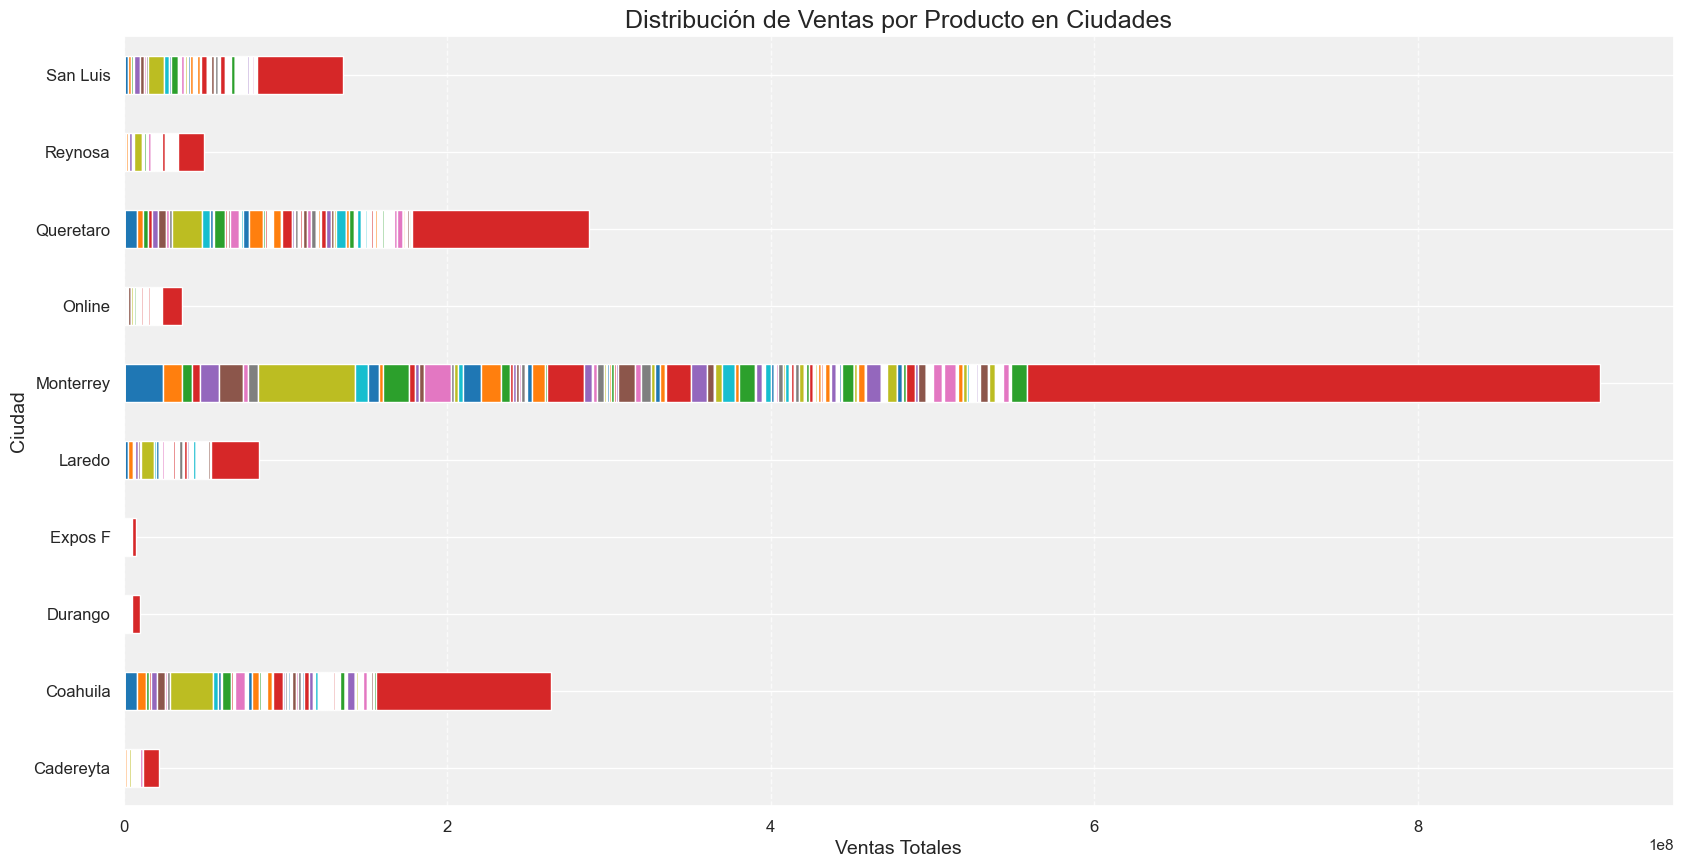

In [8]:
grafica = df_final.groupby(['Ciudad','Encoded Products']).sum().unstack().plot(kind='barh', y='total', stacked=True, figsize=(20, 10), color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
grafica.set_title('Distribución de Ventas por Producto en Ciudades', fontsize=18)
grafica.set_xlabel('Ventas Totales', fontsize=14)
grafica.set_ylabel('Ciudad', fontsize=14)
grafica.grid(axis='x', linestyle='--', alpha=0.7)
grafica.set_facecolor('#f0f0f0')  
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
grafica.legend().set_visible(False)
plt.show()


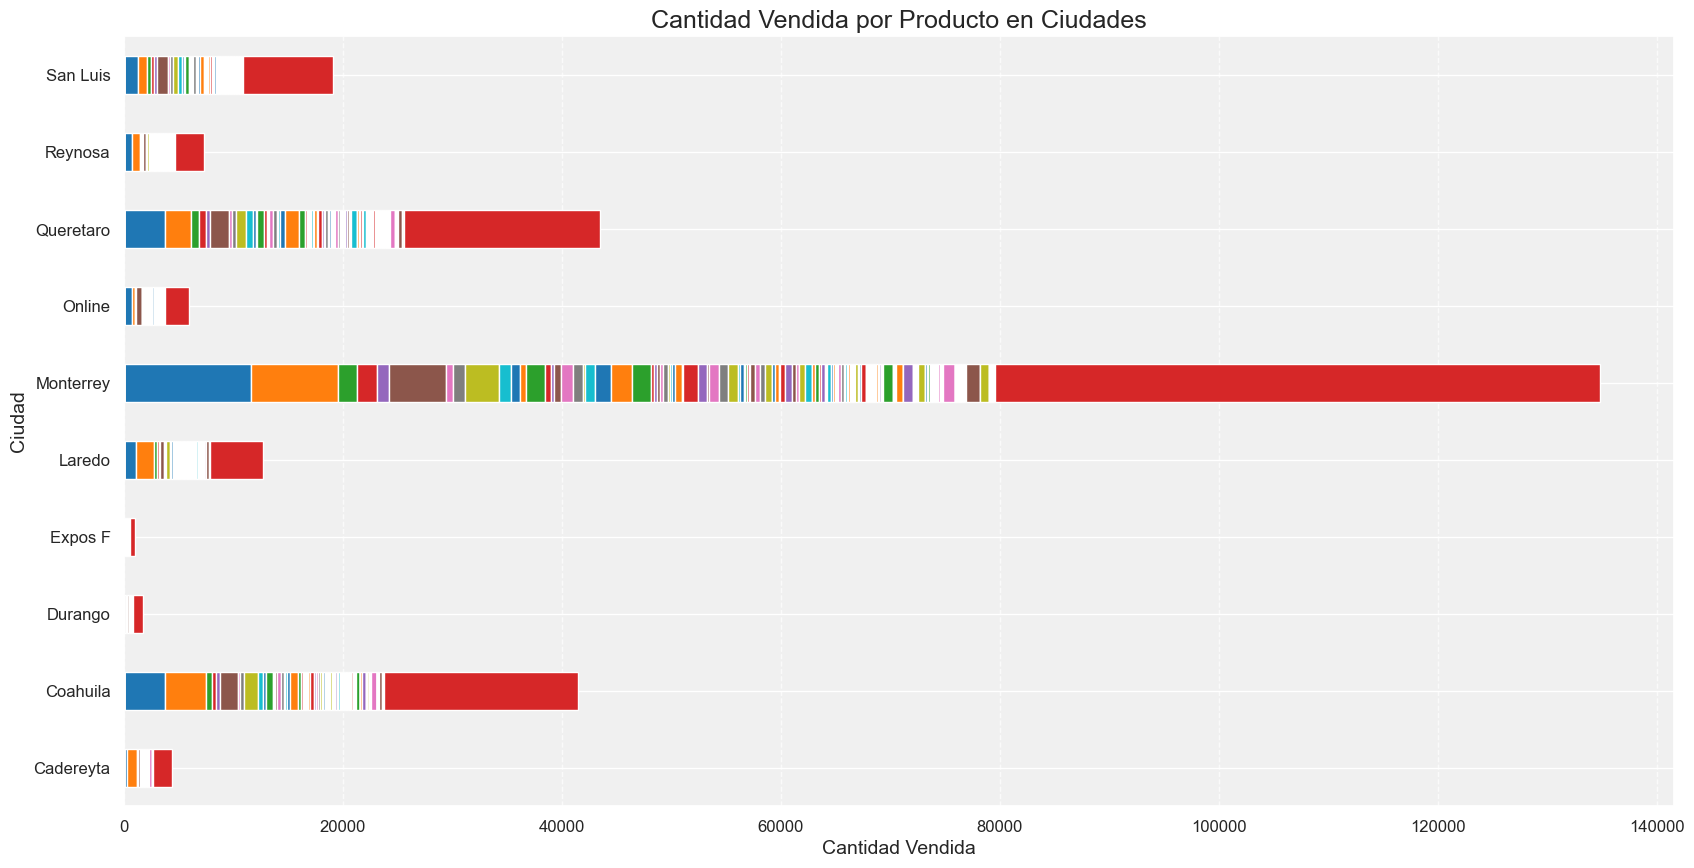

In [9]:
grafica = df_final.groupby(['Ciudad','Encoded Products']).sum().unstack().plot(kind='barh', y='ctdad', stacked=True, figsize=(20, 10), color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
grafica.set_title('Cantidad Vendida por Producto en Ciudades', fontsize=18)
grafica.set_xlabel('Cantidad Vendida', fontsize=14)
grafica.set_ylabel('Ciudad', fontsize=14)
grafica.grid(axis='x', linestyle='--', alpha=0.7)
grafica.set_facecolor('#f0f0f0') 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
grafica.legend().set_visible(False) 
plt.savefig('Cantidad Vendida por Producto en Ciudades.png', dpi=300, bbox_inches='tight')
plt.show()


In [10]:
df_final.groupby('Ciudad')['ctdad'].sum().sort_values(ascending=False).head(3)

Ciudad
Monterrey    134809.5
Queretaro     43501.5
Coahuila      41450.5
Name: ctdad, dtype: float64

In [11]:
df_final.groupby('Ciudad')['total'].sum().sort_values(ascending=False).head(3)

Ciudad
Monterrey    9.125314e+08
Queretaro    2.876827e+08
Coahuila     2.642039e+08
Name: total, dtype: float64

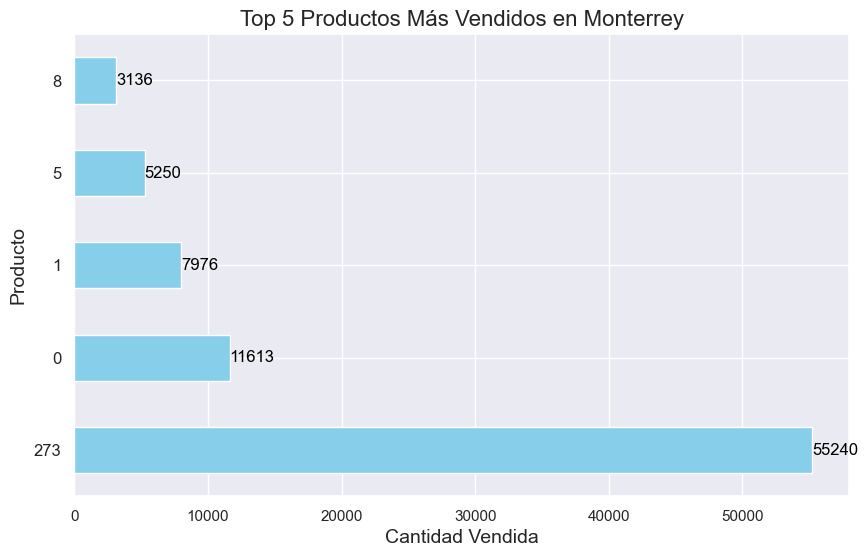

In [12]:
Mty = df_final[df_final['Ciudad'] == 'Monterrey']
top_5_productos = Mty.groupby(['Encoded Products'])['ctdad'].sum().sort_values(ascending=False).head(5)
plt.figure(figsize=(10, 6))
top_5_productos.plot(kind='barh', color='skyblue')
plt.title('Top 5 Productos Más Vendidos en Monterrey', fontsize=16)
plt.xlabel('Cantidad Vendida', fontsize=14)
plt.ylabel('Producto', fontsize=14)
plt.xticks(rotation=0)
plt.yticks(fontsize=12)
for i, v in enumerate(top_5_productos):
    plt.text(v + 0.1, i, str(int(v)), ha='left', va='center', fontsize=12, color='black')
plt.savefig('Top 5 Productos Más Vendidos en Monterrey.png', dpi=300, bbox_inches='tight')
plt.show()


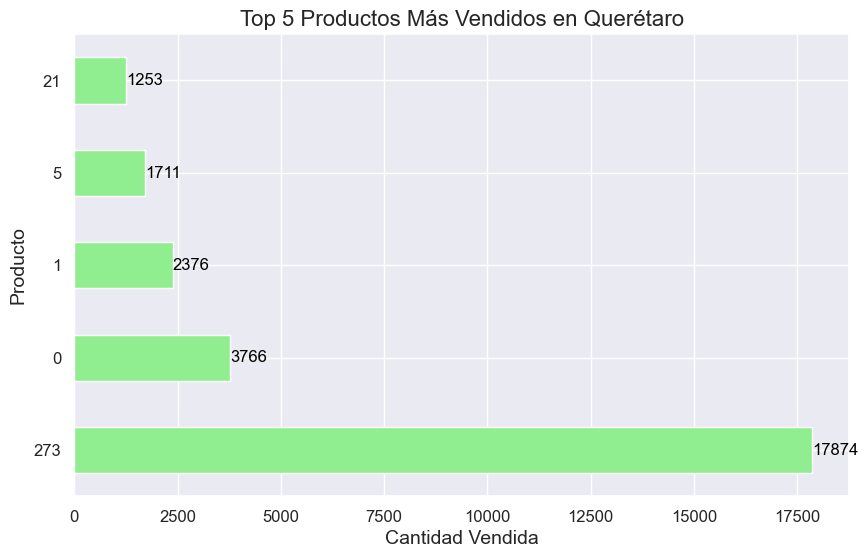

In [13]:
Qro = df_final[df_final['Ciudad'] == 'Queretaro']
top_5_productos_Qro = Qro.groupby(['Encoded Products'])['ctdad'].sum().sort_values(ascending=False).head(5)
plt.figure(figsize=(10, 6))
top_5_productos_Qro.plot(kind='barh', color='lightgreen')
plt.title('Top 5 Productos Más Vendidos en Querétaro', fontsize=16)
plt.xlabel('Cantidad Vendida', fontsize=14)
plt.ylabel('Producto', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
for i, v in enumerate(top_5_productos_Qro):
    plt.text(v + 0.1, i, str(int(v)), ha='left', va='center', fontsize=12, color='black')
plt.savefig('Top 5 Productos Más Vendidos en Queretaro.png', dpi=300, bbox_inches='tight')
plt.show()


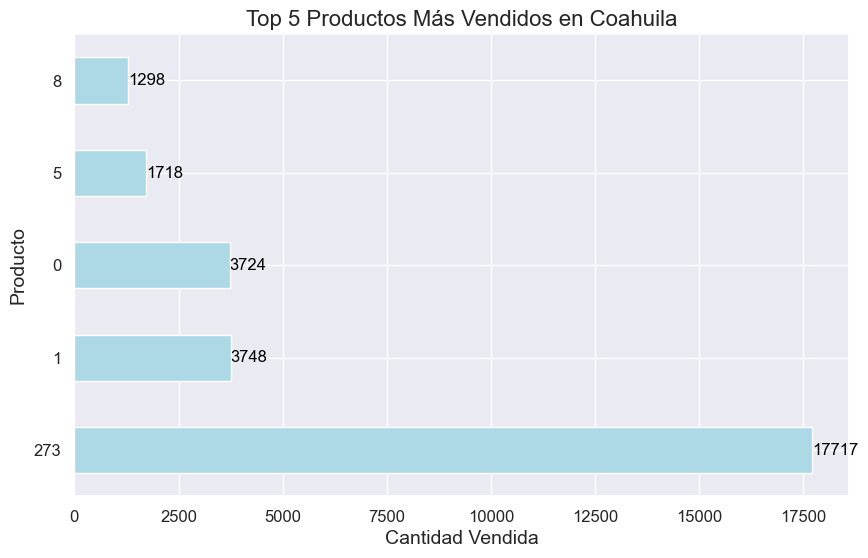

In [14]:
Chl = df_final[df_final['Ciudad'] == 'Coahuila']
top_5_productos_Chl = Chl.groupby(['Encoded Products'])['ctdad'].sum().sort_values(ascending=False).head(5)
plt.figure(figsize=(10, 6))
top_5_productos_Chl.plot(kind='barh', color='lightblue')
plt.title('Top 5 Productos Más Vendidos en Coahuila', fontsize=16)
plt.xlabel('Cantidad Vendida', fontsize=14)
plt.ylabel('Producto', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
for i, v in enumerate(top_5_productos_Chl):
    plt.text(v + 0.1, i, str(int(v)), ha='left', va='center', fontsize=12, color='black')
plt.savefig('Top 5 Productos Más Vendidos en Coahuila.png', dpi=300, bbox_inches='tight')
plt.show()


In [15]:
df_final['date'] = pd.to_datetime(df_final['date'])
sales_daily = df_final.groupby('date').ctdad.sum()
sales_daily_df = pd.DataFrame(sales_daily)
sales_weekly_mean = sales_daily_df['ctdad'].resample('W').mean()
sales_monthly_mean = sales_daily_df['ctdad'].resample('M').mean()

In [113]:
df_final

,Encoded Products,date,total,ctdad,Ciudad
0,11,2022-01-02,0.0,0.0,Cadereyta
1,6,2022-01-02,0.0,0.0,Cadereyta
2,24,2022-01-02,0.0,0.0,Cadereyta
3,15,2022-01-02,0.0,0.0,Cadereyta
4,9,2022-01-02,0.0,0.0,Cadereyta
...,...,...,...,...,...
305645,273,2023-12-31,0.0,0.0,San Luis
305646,273,2023-12-31,0.0,0.0,San Luis
305647,273,2023-12-31,0.0,0.0,San Luis
305648,273,2023-12-31,0.0,0.0,San Luis


In [112]:
sales_daily

date
2022-01-02    35.0
2022-01-03    17.5
2022-01-04     3.5
2022-01-05    14.0
2022-01-06     7.0
              ... 
2023-12-27    45.5
2023-12-28    17.5
2023-12-29    31.5
2023-12-30    28.0
2023-12-31     7.0
Name: ctdad, Length: 729, dtype: float64

# Forecast todas las regiones, todos los productos

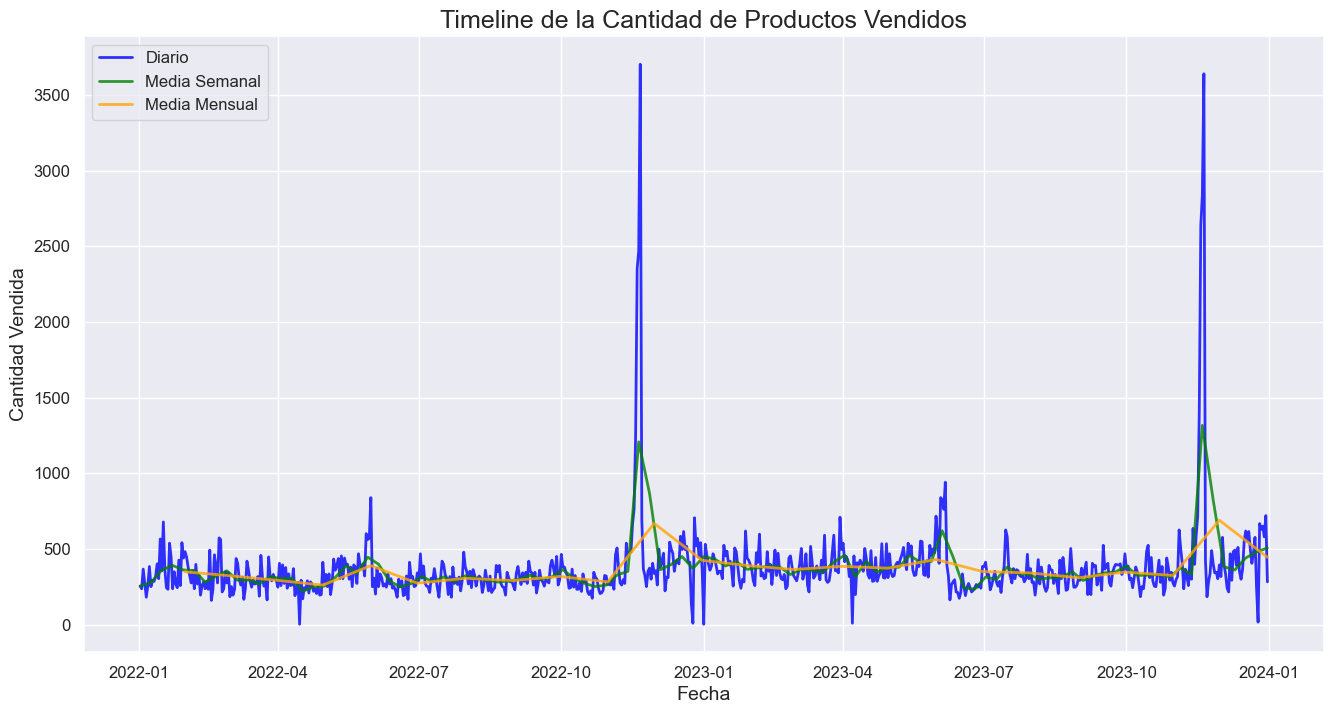

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
sns.set_style("darkgrid")
plt.plot(sales_daily, label='Diario', color='blue', linewidth=2, alpha=0.8)
plt.plot(sales_weekly_mean, label='Media Semanal', color='green', linewidth=2, alpha=0.8)
plt.plot(sales_monthly_mean, label='Media Mensual', color='orange', linewidth=2, alpha=0.8)

plt.title('Timeline de la Cantidad de Productos Vendidos', fontsize=18)
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Cantidad Vendida', fontsize=14)

plt.legend(fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('Timeline de la Cantidad de Productos Vendidos.png', dpi=300, bbox_inches='tight')

plt.show()

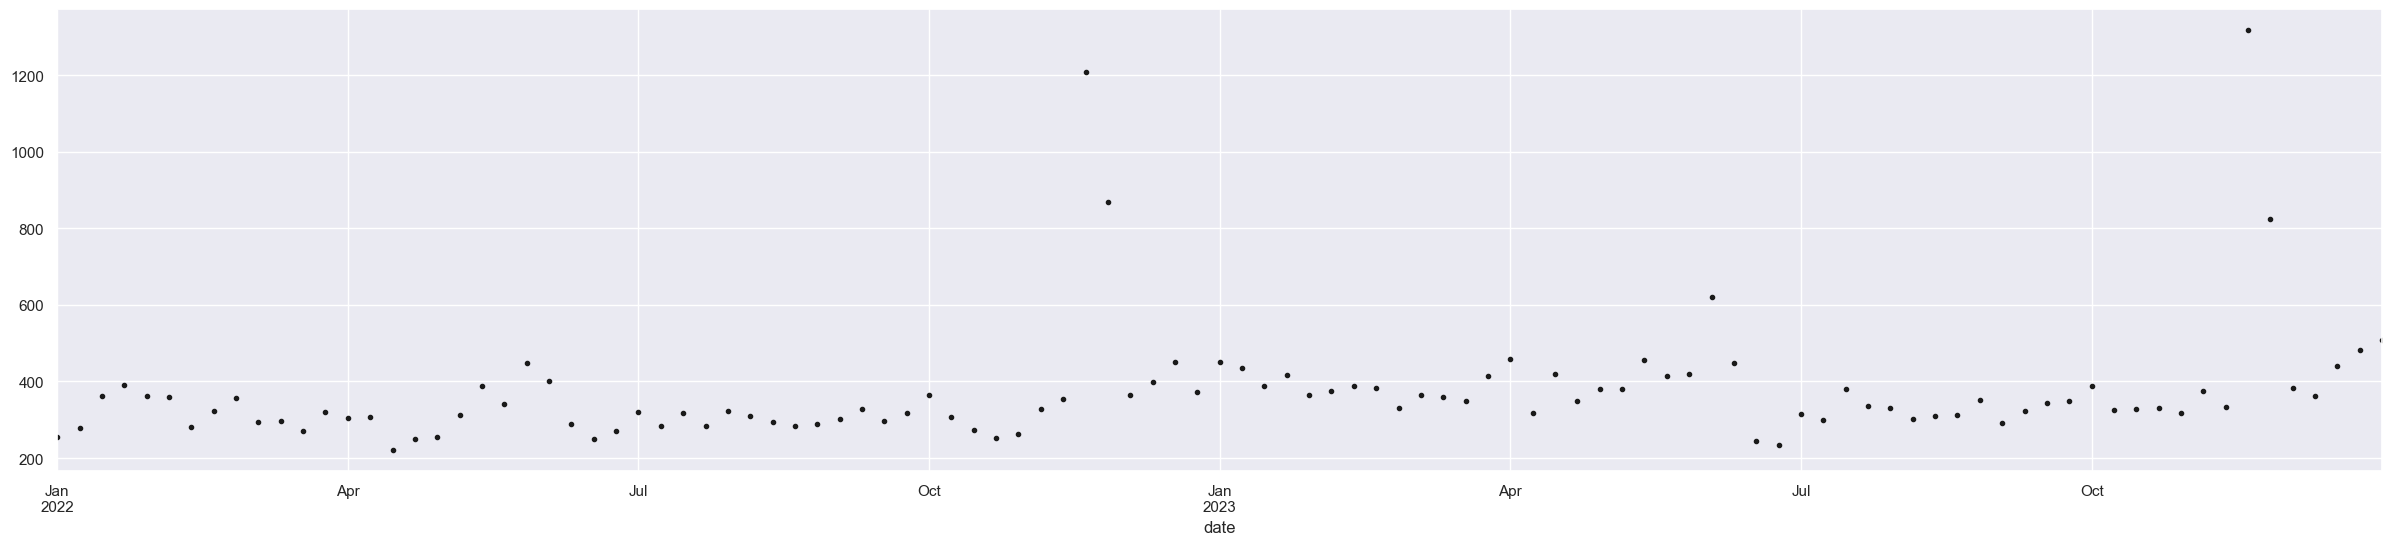

In [26]:
sales_weekly_mean.plot(style='k.', figsize=(30, 6))
plt.show()

In [27]:
sales_monthly = df_final.groupby([df_final['date'].dt.year.rename('year'), df_final['date'].dt.to_period("M").rename('month')])['ctdad'].sum().reset_index()
sales_monthly['month'] = sales_monthly['month'].astype(str)

In [28]:
sales_weekly = df_final.groupby([df_final['date'].dt.year.rename('year'), df_final['date'].dt.to_period("W").rename('week')])['ctdad'].sum().reset_index()
sales_weekly['week'] = sales_weekly['week'].astype(str)

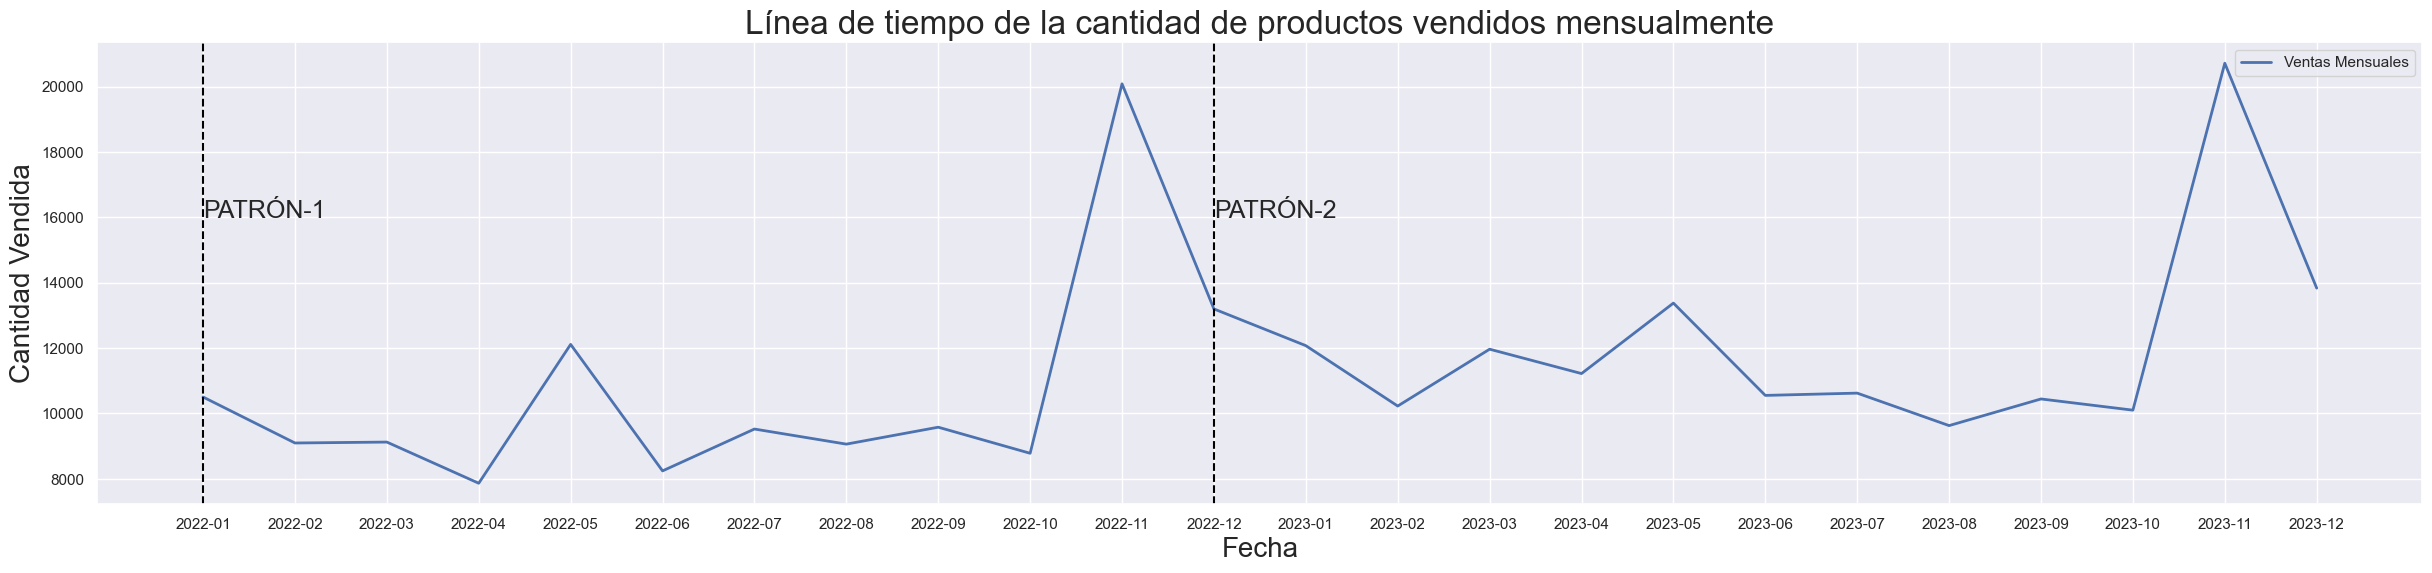

In [29]:
sns.set_style("darkgrid")
plt.rc('font', size=18)  # Aumenta el tamaño de la fuente
plt.figure(figsize=(30, 6))
plt.plot(sales_monthly['month'], sales_monthly['ctdad'], label='Ventas Mensuales', linewidth=2)
plt.legend()

xcoords = ['2022-01', '2022-12']
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')

plt.annotate('PATRÓN-1', ('2022-01', 16000))
plt.annotate('PATRÓN-2', ('2022-12', 16000))
plt.annotate('', ('2023-12', 16000))

plt.title('Línea de tiempo de la cantidad de productos vendidos mensualmente', fontsize=24)  # Aumenta el tamaño del título
plt.xlabel('Fecha', fontsize=20)  # Aumenta el tamaño del nombre del eje x
plt.ylabel('Cantidad Vendida', fontsize=20)  # Aumenta el tamaño del nombre del eje y
plt.savefig('Linea de tiempo de la cantidad de productos vendidos mensualmente.png', dpi=300, bbox_inches='tight')

plt.show()



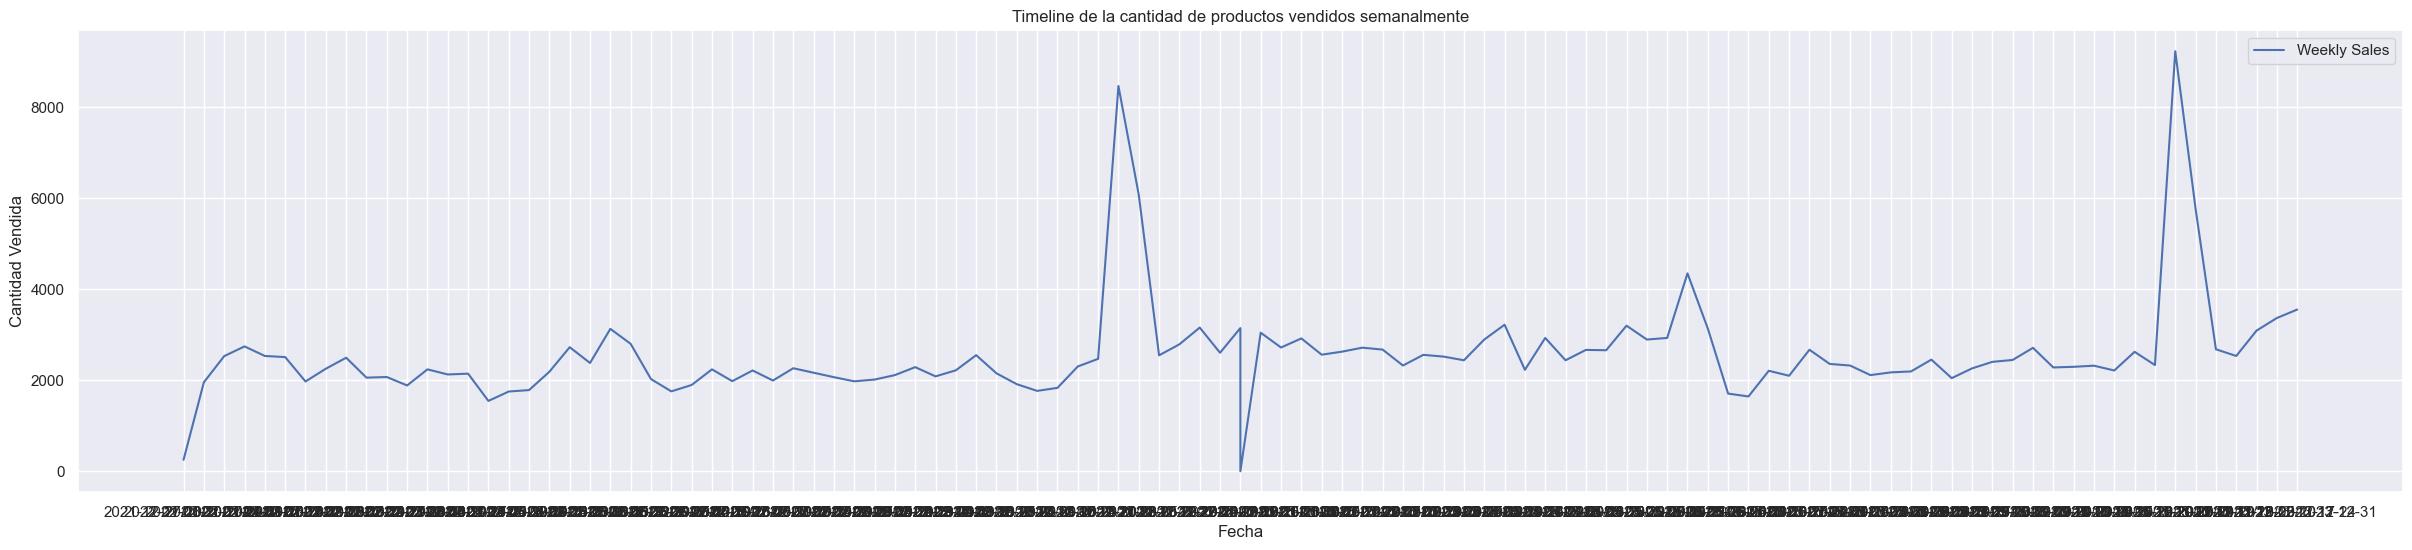

In [30]:
plt.figure(figsize=(30, 6))
plt.plot(sales_weekly['week'],sales_weekly['ctdad'], label='Weekly Sales')
plt.title('Timeline de la cantidad de productos vendidos semanalmente')
plt.xlabel('Fecha')
plt.ylabel('Cantidad Vendida')
plt.legend()

In [31]:
sales_weekly = pd.DataFrame(df_final.groupby([df_final['date'].dt.year.rename('year'), df_final['date'].dt.to_period("W").rename('week')])['ctdad'].sum().reset_index().drop('year', axis=1).set_index('week'))
sales_weekly

,ctdad
week,
2021-12-27/2022-01-02,255.5
2022-01-03/2022-01-09,1956.5
2022-01-10/2022-01-16,2530.5
2022-01-17/2022-01-23,2744.0
2022-01-24/2022-01-30,2534.0
...,...
2023-11-27/2023-12-03,2681.0
2023-12-04/2023-12-10,2534.0
2023-12-11/2023-12-17,3090.5


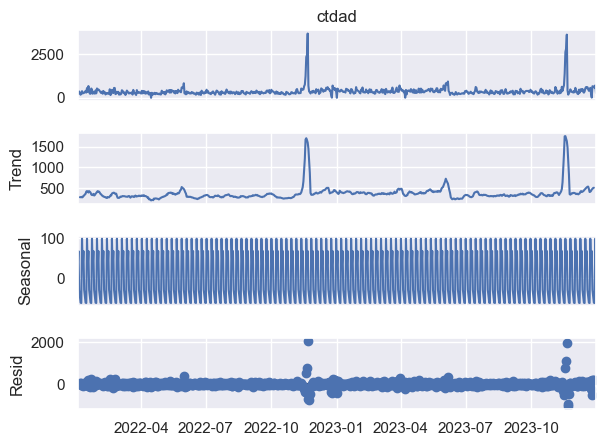

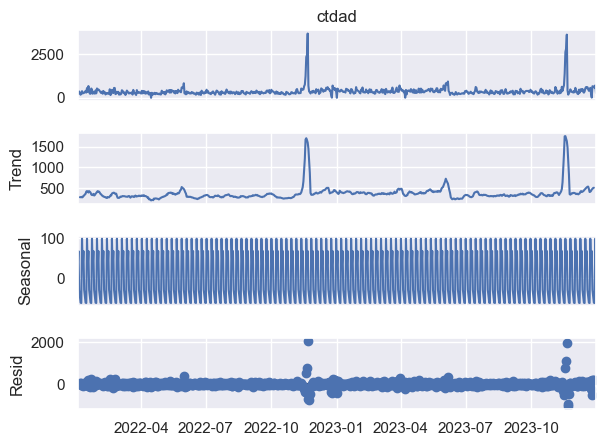

In [32]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_data = seasonal_decompose(sales_daily, model="additive")
decompose_data.plot()

In [33]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(sales_daily, autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -8.208417865839433
2. P-Value :  6.923237357227161e-13
3. Num Of Lags :  7
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 721
5. Critical Values :
	 1% :  -3.4394522667904153
	 5% :  -2.8655569894909805
	 10% :  -2.568909106765338


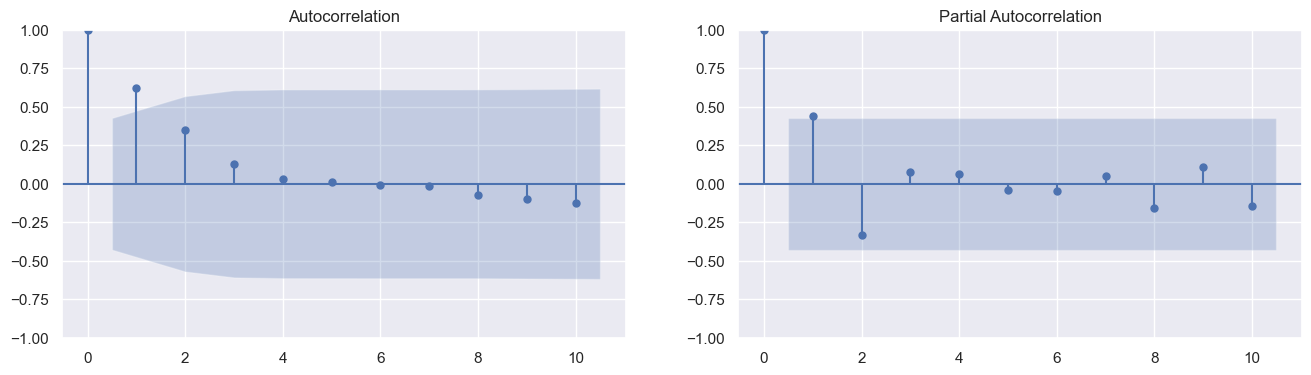

In [34]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

lag_acf = acf(sales_daily, nlags=20)
lag_pacf = pacf(sales_daily, nlags=20, method='ols')

fig, ax = plt.subplots(1,2,figsize=(16,4))
plot_acf(lag_acf, ax=ax[0])
plot_pacf(lag_pacf, ax=ax[1])

plt.savefig('Autocorrelation and Partial Autocorrelation todos productos todas regiones.png', dpi=300, bbox_inches='tight')
plt.show()

In [35]:
arima_model=auto_arima(sales_weekly_mean, start_p=1,d=1,start_q=1,
                      max_p=5,max_q=5,max_d=5,m=12,
                        start_P=0,D=1,start_Q=0,max_P=5,max_D=5,max_Q=5,
                      seasonal=True,
                       trace=True,
                      error_action="ignore",
                      suppress_warnings=True,
                      stepwise=True,n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1248.685, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1225.619, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1216.109, Time=0.11 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1244.473, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1216.566, Time=0.17 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1217.209, Time=0.34 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1217.909, Time=0.08 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1217.769, Time=1.03 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1222.996, Time=0.06 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.16 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=inf, Time=0.17 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1222.632, Time=0.11 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=inf, Time=0.26 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : 

In [36]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  105
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -605.055
Date:                            Thu, 14 Mar 2024   AIC                           1216.109
Time:                                    18:24:16   BIC                           1223.675
Sample:                                01-02-2022   HQIC                          1219.163
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7177      0.053    -13.509      0.000      -0.822      -0.614
ma.S.L12      -0.7544      0.115     -6.578      0.000      -0.979      -0.530
sigma2      2.701e+04   1416.814     19.061      0.000    2.42e+04    2.98e+04
===================================================================================
Ljung-Box (L1) (Q):                   7.66   Jarque-Bera (JB):              1209.69
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):              11.95   Skew:                             3.33
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
month_number = sales_weekly_mean.index.month

# Convierte la serie de números de mes en una variable exógena DataFrame
exog_variable_month = pd.DataFrame(month_number, index=sales_weekly_mean.index)

In [38]:
exog_variables = pd.concat([exog_variable_month], axis=1)

In [39]:
from sklearn.model_selection import train_test_split
size=int(len(sales_weekly_mean)*0.66)
#train_exog, test_exog = train_test_split(exog_variables, test_size = 0.10, shuffle = False)
train_exog,test_exog=exog_variables[0:size],exog_variables[size:len(exog_variables)]

In [40]:
size=int(len(sales_weekly_mean)*0.66)
X_train,X_test=sales_weekly_mean[0:size],sales_weekly_mean[size:len(sales_weekly_mean)]

model=SARIMAX(X_train,
             exog=train_exog,
             order=(0,1,1),
             seasonal_order=(0,1,1,12))
result=model.fit()
result.summary()

c:\Users\jesus\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              ctdad   No. Observations:                   69
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -362.241
Date:                            Thu, 14 Mar 2024   AIC                            732.483
Time:                                    18:24:16   BIC                            740.584
Sample:                                01-02-2022   HQIC                           735.624
                                     - 04-23-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
date          -4.0335     65.669     -0.061      0.951    -132.743     124.676
ma.L1         -0.4547      0.100     -4.568      0.000      -0.650      -0.260
ma.S.L12      -0.9919      7.750     -0.128      0.898     -16.181      14.197
sigma2      1.693e+04    1.3e+05      0.130      0.896   -2.38e+05    2.72e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.66   Jarque-Bera (JB):              1117.47
Prob(Q):                              0.20   Prob(JB):                         0.00
Heteroskedasticity (H):               1.46   Skew:                             3.15
Prob(H) (two-sided):                  0.42   Kurtosis:                        23.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [41]:
start_index=0
end_index=len(X_train)-1
train_prediction=result.predict(start_index,end_index, exog = train_exog)

st_index=len(X_train)
ed_index=len(sales_weekly_mean)-1
prediction=result.predict(st_index,ed_index, exog = test_exog)

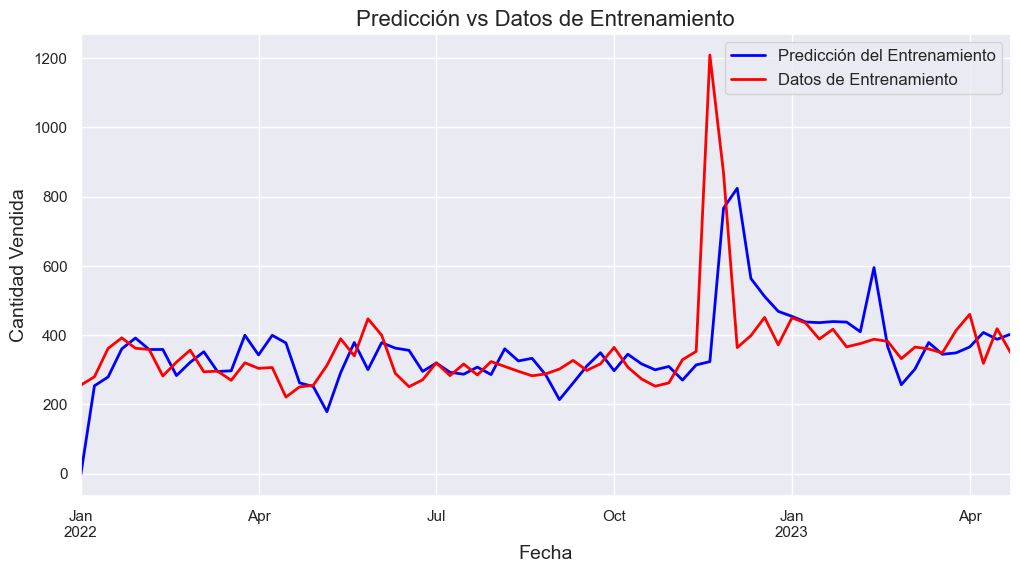

In [42]:
plt.figure(figsize=(12, 6))

train_prediction.plot(legend=True, color='blue', linewidth=2, label='Predicción del Entrenamiento')
X_train.plot(legend=True, color='red', linewidth=2, label='Datos de Entrenamiento')

plt.title('Predicción vs Datos de Entrenamiento', fontsize=16)
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Cantidad Vendida', fontsize=14)
plt.legend(fontsize=12)
plt.savefig('Predicción vs Datos de Entrenamiento TODO.png', dpi=300, bbox_inches='tight')
plt.show()


In [43]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Suponiendo que X_test son los valores verdaderos y prediction son los valores predichos

# Calcula el MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(X_train, train_prediction)
print('MAPE:', mape)
print('Absolute Error:', metrics.mean_absolute_error(X_train, train_prediction))
print('MSE:', metrics.mean_squared_error(X_train, train_prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(X_train, train_prediction)))

MAPE: 19.590031090732605
Absolute Error: 74.35051458014021
MSE: 19858.63645505101
RMSE: 140.92067433507054


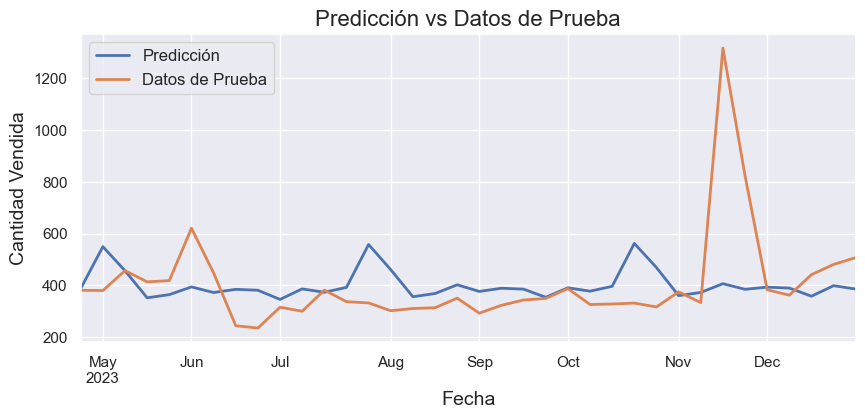

In [44]:
plt.figure(figsize=(10, 4))

prediction.plot(legend=True, linewidth=2, label='Predicción')
X_test.plot(legend=True, linewidth=2, label='Datos de Prueba')

plt.title('Predicción vs Datos de Prueba', fontsize=16)
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Cantidad Vendida', fontsize=14)
plt.legend(fontsize=12)
plt.savefig('Predicción vs Datos de Prueba TODO.png', dpi=300, bbox_inches='tight')
plt.show()

In [45]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Suponiendo que X_test son los valores verdaderos y prediction son los valores predichos

# Calcula el MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(X_test, prediction)
print('MAPE:', mape)

# Calcula el COD (Coefficient of Determination)
cod = r2_score(X_test, prediction)
# print('COD:', cod)
print('Absolute Error:', metrics.mean_absolute_error(X_test, prediction))
print('MSE:', metrics.mean_squared_error(X_test, prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(X_test, prediction)))

MAPE: 24.955440982135617
Absolute Error: 111.97436401732041
MSE: 38347.4083695788
RMSE: 195.82494317522168


In [46]:
date_range = pd.date_range(start='2024-01-01', periods=92, freq='W')

# Extrae el número de mes de cada fecha en el rango
exog_data = pd.DataFrame({'date': date_range})
exog_data['month'] = exog_data['date'].dt.month

# Asegúrate de que la columna 'date' sea el índice del DataFrame
exog_data.set_index('date', inplace=True)

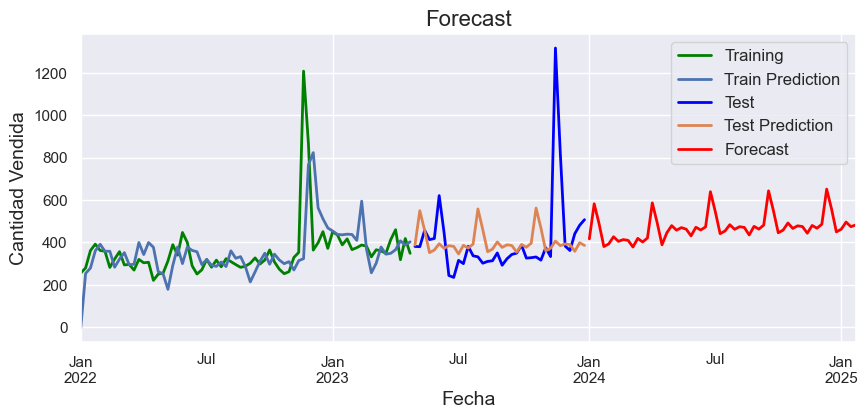

In [47]:
forecast=result.predict(len(sales_weekly_mean), (len(sales_weekly_mean)-1)+56, exog = exog_data).rename('Forecast')

plt.figure(figsize=(10, 4))

X_train.plot(label="Training", color='green', linewidth=2)
train_prediction.plot(legend=True, linewidth=2, label='Train Prediction')
X_test.plot(label="Test", color='blue', linewidth=2)
prediction.plot(legend=True, linewidth=2, label='Test Prediction')
forecast.plot(label="Forecast", color="red", linewidth=2)
plt.legend(loc="upper right", fontsize=12)

plt.title('Forecast', fontsize=16)
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Cantidad Vendida', fontsize=14)
plt.savefig('Forecast TODO.png', dpi=300, bbox_inches='tight')
plt.show()

# Para el producto 273, en todas las regiones

In [48]:
df_filtered = df_final[df_final['Encoded Products'] == 273]

df_filtered = df_filtered.sort_values('date')
fecha_min = df_filtered['date'].min()
fecha_max = df_filtered['date'].max()
rango_fechas = pd.date_range(start=fecha_min, end=fecha_max, freq='D')
df_rango_fechas = pd.DataFrame({'date': rango_fechas})

df_final_new = pd.merge(df_rango_fechas, df_filtered, on='date', how='left')
df_final_new['date'] = df_final_new['date'].fillna(method='ffill')
df_final_new.fillna(0, inplace=True)
df_final_new

C:\Users\jesus\AppData\Local\Temp\ipykernel_4568\2983186353.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_final_new['date'] = df_final_new['date'].fillna(method='ffill')


,date,Encoded Products,total,ctdad,Ciudad
0,2022-04-01,273.0,0.00,0.0,Cadereyta
1,2022-04-01,273.0,0.00,0.0,Queretaro
2,2022-04-01,273.0,0.00,0.0,Online
3,2022-04-01,273.0,0.00,0.0,Monterrey
4,2022-04-01,273.0,25080.09,3.5,Laredo
...,...,...,...,...,...
116984,2023-12-31,273.0,21098.77,3.5,Monterrey
116985,2023-12-31,273.0,0.00,0.0,Monterrey
116986,2023-12-31,273.0,0.00,0.0,Monterrey
116987,2023-12-31,273.0,0.00,0.0,Online


In [50]:
df_final_new['date'] = pd.to_datetime(df_final_new['date'])
sales_daily = df_final_new.groupby('date').ctdad.sum()
sales_daily_df = pd.DataFrame(sales_daily)
sales_weekly_mean = sales_daily_df['ctdad'].resample('W').mean()
sales_monthly_mean = sales_daily_df['ctdad'].resample('M').mean()


In [51]:
sales_daily

date
2022-04-01      3.5
2022-04-02      0.0
2022-04-03      0.0
2022-04-04     10.5
2022-04-05      0.0
              ...  
2023-12-27    381.5
2023-12-28    448.0
2023-12-29    336.0
2023-12-30    507.5
2023-12-31    168.0
Name: ctdad, Length: 640, dtype: float64

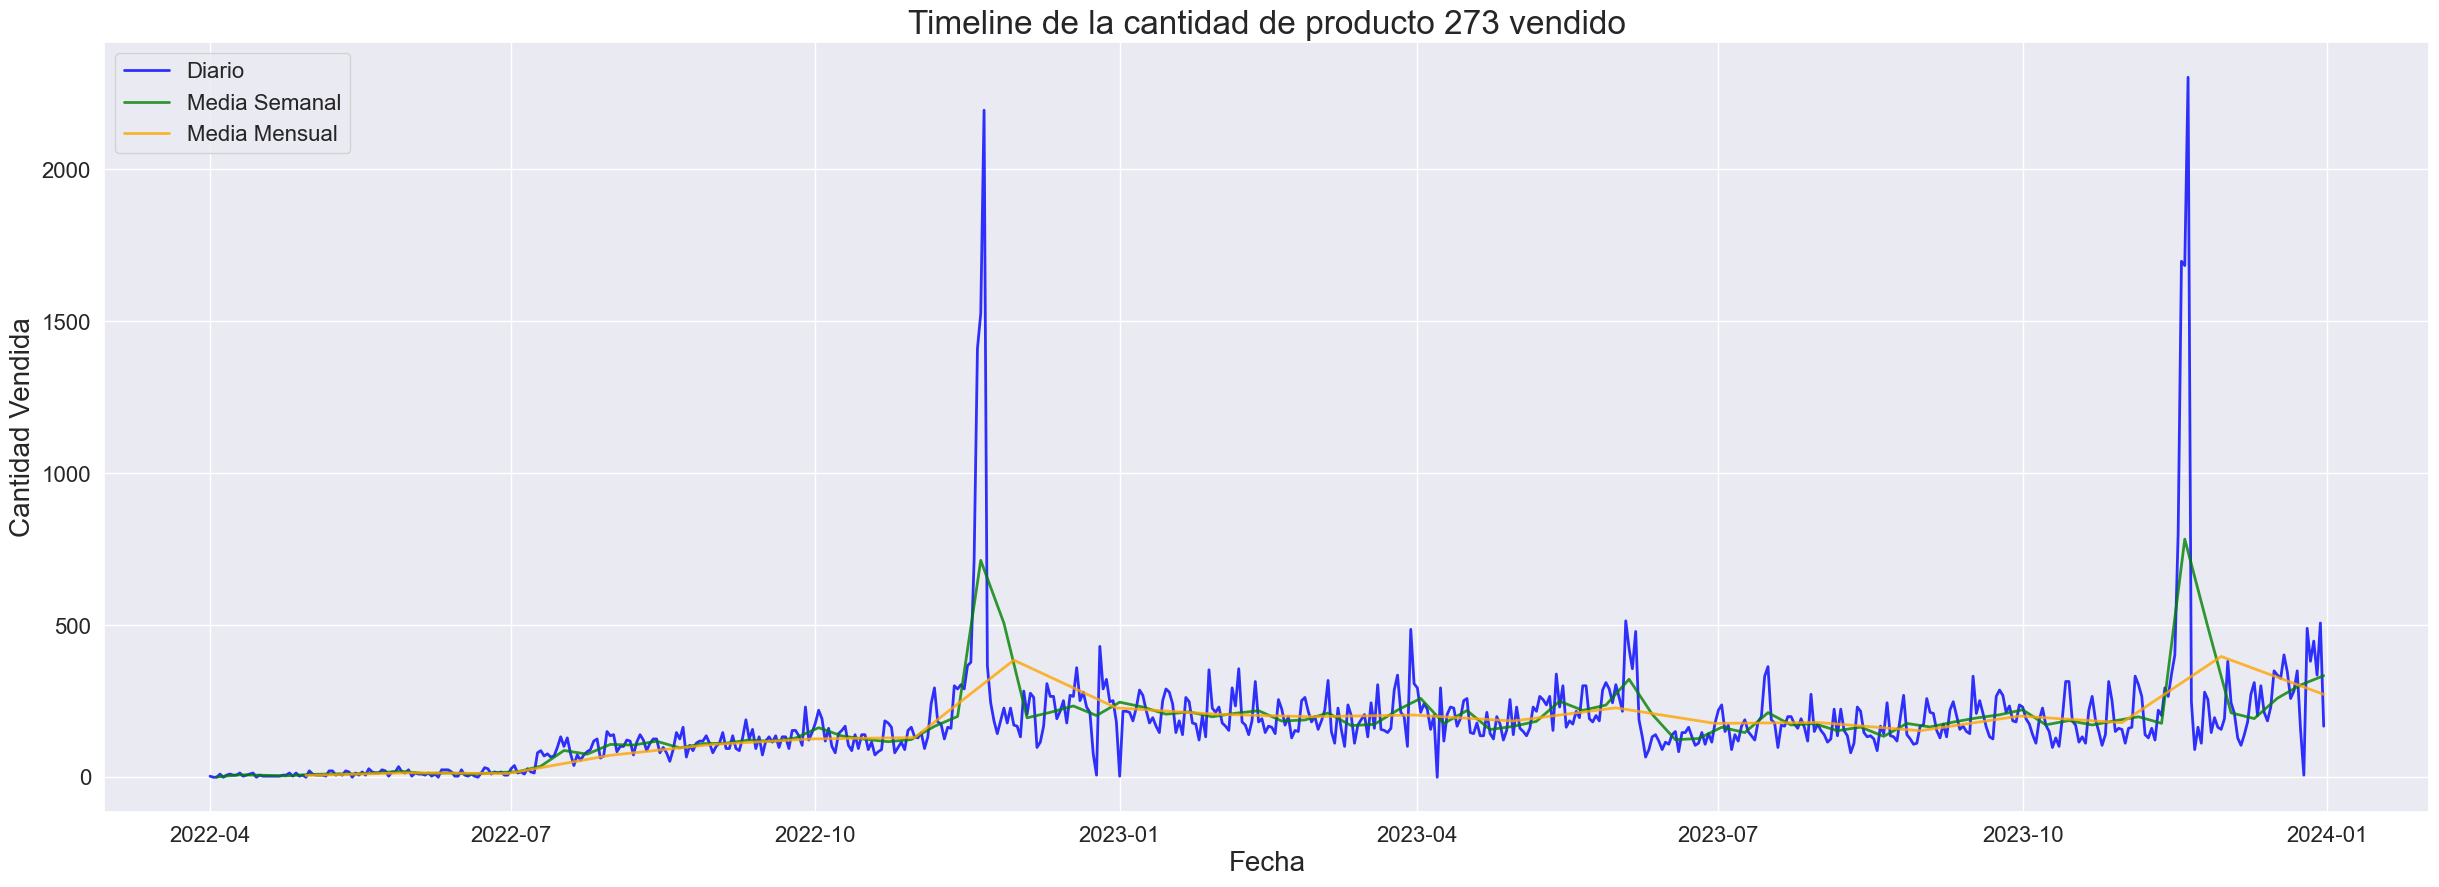

In [52]:
plt.figure(figsize=(30, 10))
sns.set_style("darkgrid")

plt.plot(sales_daily, label='Diario', color='blue', linewidth=2, alpha=0.8)
plt.plot(sales_weekly_mean, label='Media Semanal', color='green', linewidth=2, alpha=0.8)
plt.plot(sales_monthly_mean, label='Media Mensual', color='orange', linewidth=2, alpha=0.8)

plt.title('Timeline de la cantidad de producto 273 vendido', fontsize=24)
plt.xlabel('Fecha', fontsize=20)
plt.ylabel('Cantidad Vendida', fontsize=20)

plt.legend(fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('Timeline de la cantidad de producto 273 vendido.png', dpi=300, bbox_inches='tight')
plt.show()

In [53]:
sales_monthly = df_final_new.groupby([df_final_new['date'].dt.year.rename('year'), df_final_new['date'].dt.to_period("M").rename('month')])['ctdad'].sum().reset_index()
sales_monthly['month'] = sales_monthly['month'].astype(str)

In [54]:
sales_weekly = df_final_new.groupby([df_final_new['date'].dt.year.rename('year'), df_final_new['date'].dt.to_period("W").rename('week')])['ctdad'].sum().reset_index()
sales_weekly['week'] = sales_weekly['week'].astype(str)

In [55]:
sales_weekly = pd.DataFrame(df_final_new.groupby([df_final_new['date'].dt.year.rename('year'), df_final_new['date'].dt.to_period("W").rename('week')])['ctdad'].sum().reset_index().drop('year', axis=1).set_index('week'))


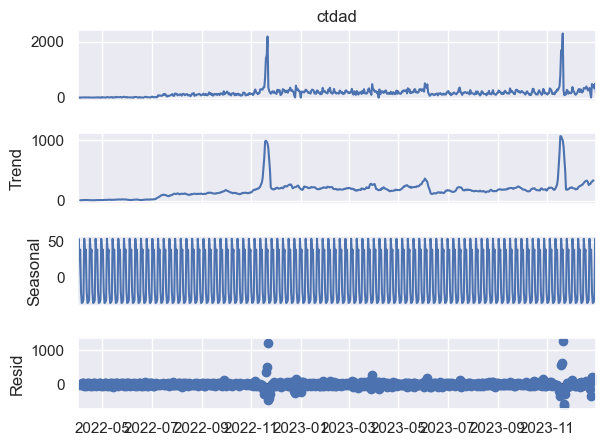

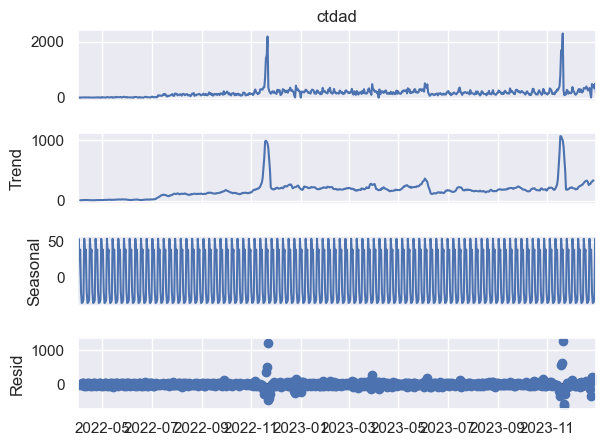

In [56]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_data = seasonal_decompose(sales_daily, model="additive")
decompose_data.plot()

In [57]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(sales_daily, autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -7.005782819309597
2. P-Value :  7.128373305083688e-10
3. Num Of Lags :  4
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 635
5. Critical Values :
	 1% :  -3.4406900498266193
	 5% :  -2.8661023102613137
	 10% :  -2.569199643499287


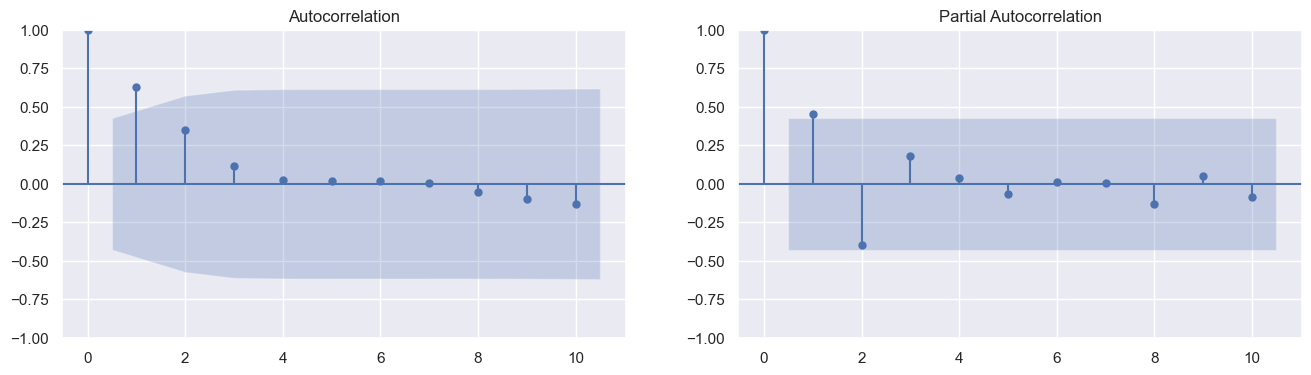

In [58]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

lag_acf = acf(sales_daily, nlags=20)
lag_pacf = pacf(sales_daily, nlags=20, method='ols')

fig, ax = plt.subplots(1,2,figsize=(16,4))
plot_acf(lag_acf, ax=ax[0])
plot_pacf(lag_pacf, ax=ax[1])

plt.savefig('Autocorrelation and Partial Autocorrelation producto 273.png', dpi=300, bbox_inches='tight')
plt.show()

In [59]:
arima_model=auto_arima(sales_weekly_mean, start_p=1,d=1,start_q=1,
                      max_p=5,max_q=5,max_d=5,m=12,
                        start_P=0,D=1,start_Q=0,max_P=5,max_D=5,max_Q=5,
                      seasonal=True,
                       trace=True,
                      error_action="ignore",
                      suppress_warnings=True,
                      stepwise=True,n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1003.085, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=988.336, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=982.121, Time=0.12 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1002.189, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=983.481, Time=0.18 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=983.579, Time=0.32 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=985.267, Time=0.08 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=985.436, Time=0.72 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=985.215, Time=0.07 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=972.951, Time=0.27 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=0.48 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=974.719, Time=0.68 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=975.974, Time=0.26 sec
 ARIMA(1,1,1)(1,1,2)[12]             : 

In [60]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   92
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -480.712
Date:                            Thu, 14 Mar 2024   AIC                            971.424
Time:                                    18:24:30   BIC                            983.271
Sample:                                04-03-2022   HQIC                           976.170
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4711      0.314      1.498      0.134      -0.145       1.087
ar.L2         -0.2307      0.190     -1.216      0.224      -0.603       0.141
ma.L1         -0.8176      0.231     -3.541      0.000      -1.270      -0.365
ma.S.L12      -0.6606      0.110     -5.980      0.000      -0.877      -0.444
sigma2      1.025e+04    642.569     15.949      0.000    8988.792    1.15e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1343.06
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.38   Skew:                             3.66
Prob(H) (two-sided):                  0.42   Kurtosis:                        21.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [61]:
month_number = sales_weekly_mean.index.month

# Convierte la serie de números de mes en una variable exógena DataFrame
exog_variable_month = pd.DataFrame(month_number, index=sales_weekly_mean.index)

In [62]:
exog_variables = pd.concat([exog_variable_month], axis=1)

In [63]:
from sklearn.model_selection import train_test_split
size=int(len(sales_weekly_mean)*0.66)
#train_exog, test_exog = train_test_split(exog_variables, test_size = 0.10, shuffle = False)
train_exog,test_exog=exog_variables[0:size],exog_variables[size:len(exog_variables)]

In [64]:
size=int(len(sales_weekly_mean)*0.66)
X_train,X_test=sales_weekly_mean[0:size],sales_weekly_mean[size:len(sales_weekly_mean)]

model=SARIMAX(X_train,
             exog=train_exog,
             order=(3,0,2),
             seasonal_order=(0,1,1,12))
result=model.fit()
result.summary()

c:\Users\jesus\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\jesus\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                ctdad   No. Observations:                   60
Model:             SARIMAX(3, 0, 2)x(0, 1, [1], 12)   Log Likelihood                -287.384
Date:                              Thu, 14 Mar 2024   AIC                            590.769
Time:                                      18:24:31   BIC                            605.739
Sample:                                  04-03-2022   HQIC                           596.426
                                       - 05-21-2023                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
date           3.1159     12.371      0.252      0.801     -21.131      27.363
ar.L1          0.4661      1.197      0.389      0.697      -1.880       2.812
ar.L2          0.9990      0.328      3.049      0.002       0.357       1.641
ar.L3         -0.4671      0.893     -0.523      0.601      -2.217       1.283
ma.L1          0.1536     10.618      0.014      0.988     -20.657      20.965
ma.L2         -0.8457      8.688     -0.097      0.922     -17.873      16.182
ma.S.L12      -0.9909     11.093     -0.089      0.929     -22.733      20.752
sigma2      6398.4683      0.002    2.8e+06      0.000    6398.464    6398.473
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):               792.68
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):               5.25   Skew:                             3.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.57e+23. Standard errors may be unstable.
"""

In [65]:
start_index=0
end_index=len(X_train)-1
train_prediction=result.predict(start_index,end_index, exog = train_exog)

st_index=len(X_train)
ed_index=len(sales_weekly_mean)-1
prediction=result.predict(st_index,ed_index, exog = test_exog)

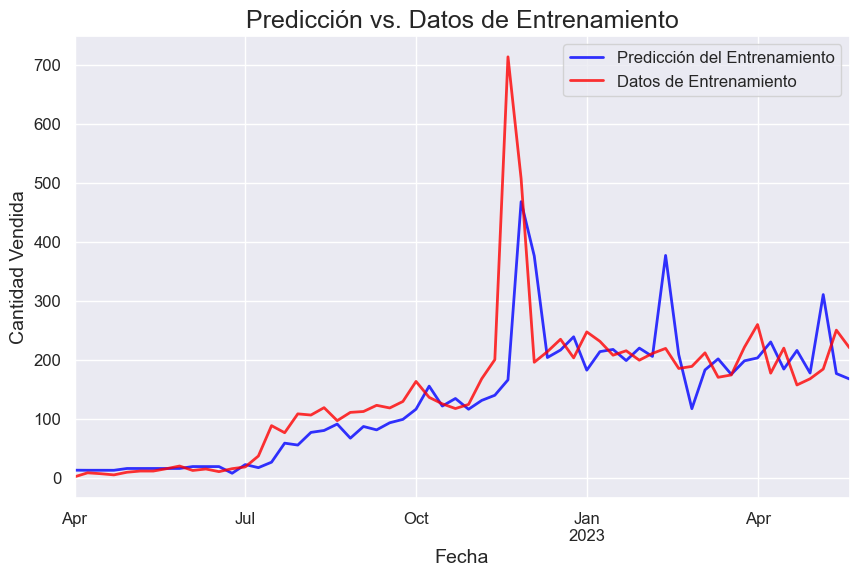

In [66]:
plt.figure(figsize=(10, 6))
sns.set_style("darkgrid")

train_prediction.plot(legend=True, color='blue', linewidth=2, alpha=0.8, label='Predicción del Entrenamiento')
X_train.plot(legend=True, color='red', linewidth=2, alpha=0.8, label='Datos de Entrenamiento')

plt.title('Predicción vs. Datos de Entrenamiento', fontsize=18)
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Cantidad Vendida', fontsize=14)

plt.legend(fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('Predicción vs. Datos de Entrenamiento 273.png', dpi=300, bbox_inches='tight')
plt.show()

In [67]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Suponiendo que X_test son los valores verdaderos y prediction son los valores predichos

# Calcula el MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(X_train, train_prediction)
print('MAPE:', mape)
print('Mean Absolute Error:', metrics.mean_absolute_error(X_train, train_prediction))
print('MSE:', metrics.mean_squared_error(X_train, train_prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(X_train, train_prediction)))

MAPE: 48.15865583319286
Mean Absolute Error: 40.560837509965616
MSE: 7220.087162724859
RMSE: 84.97109604285953


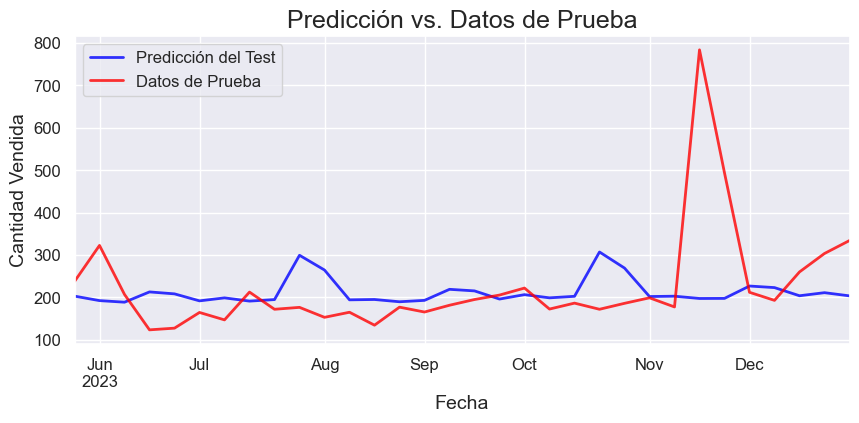

In [68]:
plt.figure(figsize=(10, 4))
sns.set_style("darkgrid")

prediction.plot(legend=True, color='blue', linewidth=2, alpha=0.8, label='Predicción del Test')
X_test.plot(legend=True, color='red', linewidth=2, alpha=0.8, label='Datos de Prueba')

plt.title('Predicción vs. Datos de Prueba', fontsize=18)
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Cantidad Vendida', fontsize=14)

plt.legend(fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('Predicción vs. Datos de Prueba 273.png', dpi=300, bbox_inches='tight')
plt.show()

In [69]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Suponiendo que X_test son los valores verdaderos y prediction son los valores predichos

# Calcula el MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(X_test, prediction)
print('MAPE:', mape)

# Calcula el COD (Coefficient of Determination)
cod = r2_score(X_test, prediction)
# print('COD:', cod)
print('Absolute Error:', metrics.mean_absolute_error(X_test, prediction))
print('MSE:', metrics.mean_squared_error(X_test, prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(X_test, prediction)))

MAPE: 29.925878844173916
Absolute Error: 75.56795330418704
MSE: 17500.917655126555
RMSE: 132.2910339181252


In [70]:
date_range = pd.date_range(start='2024-01-01', periods=92, freq='W')

# Extrae el número de mes de cada fecha en el rango
exog_data = pd.DataFrame({'date': date_range})
exog_data['month'] = exog_data['date'].dt.month

# Asegúrate de que la columna 'date' sea el índice del DataFrame
exog_data.set_index('date', inplace=True)

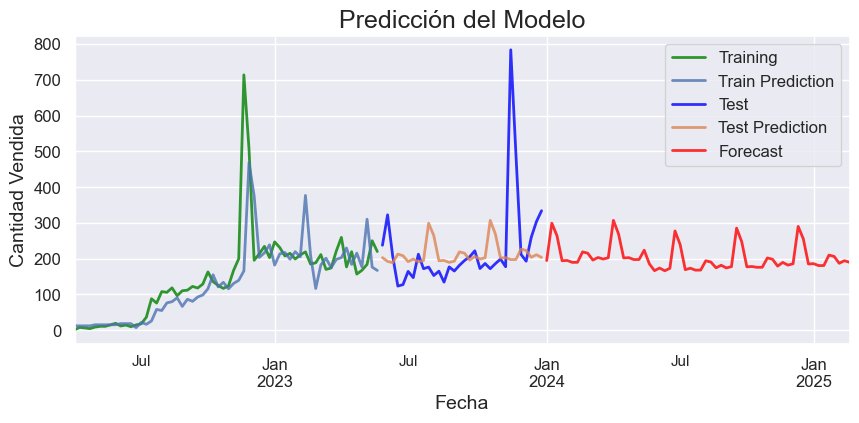

In [71]:
forecast=result.predict(len(sales_weekly_mean), (len(sales_weekly_mean)-1)+60, exog = exog_data).rename('Forecast')

plt.figure(figsize=(10, 4))
sns.set_style("darkgrid")

X_train.plot(label="Training", color='green', linewidth=2, alpha=0.8)
train_prediction.plot(legend=True, linewidth=2, alpha=0.8, label='Train Prediction')
X_test.plot(label="Test", color='blue', linewidth=2, alpha=0.8)
prediction.plot(legend=True, linewidth=2, alpha=0.8, label='Test Prediction')
forecast.plot(label="Forecast", color="red", linewidth=2, alpha=0.8)

plt.title('Predicción del Modelo', fontsize=18)
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Cantidad Vendida', fontsize=14)

plt.legend(loc="upper right", fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('Predicción del Modelo 273.png', dpi=300, bbox_inches='tight')
plt.show()

# Para el producto 0, en todas las regiones

In [72]:
df_filtered = df_final[df_final['Encoded Products'] == 0]

df_filtered = df_filtered.sort_values('date')
fecha_min = df_filtered['date'].min()
fecha_max = df_filtered['date'].max()
rango_fechas = pd.date_range(start=fecha_min, end=fecha_max, freq='D')
df_rango_fechas = pd.DataFrame({'date': rango_fechas})

df_final_new = pd.merge(df_rango_fechas, df_filtered, on='date', how='left')
df_final_new['date'] = df_final_new['date'].fillna(method='ffill')
df_final_new.fillna(0, inplace=True)
df_final_new

C:\Users\jesus\AppData\Local\Temp\ipykernel_4568\2760138922.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_final_new['date'] = df_final_new['date'].fillna(method='ffill')


,date,Encoded Products,total,ctdad,Ciudad
0,2022-01-02,0.0,0.00,0.0,Cadereyta
1,2022-01-02,0.0,0.00,0.0,Durango
2,2022-01-02,0.0,0.00,0.0,Laredo
3,2022-01-02,0.0,15167.95,7.0,Monterrey
4,2022-01-02,0.0,0.00,0.0,Coahuila
...,...,...,...,...,...
7213,2023-12-31,0.0,0.00,0.0,Durango
7214,2023-12-31,0.0,35094.99,17.5,Coahuila
7215,2023-12-31,0.0,0.00,0.0,Cadereyta
7216,2023-12-31,0.0,0.00,0.0,Reynosa


In [73]:
df_final_new['date'] = pd.to_datetime(df_final_new['date'])
sales_daily = df_final_new.groupby('date').ctdad.sum()
sales_daily_df = pd.DataFrame(sales_daily)
sales_weekly_mean = sales_daily_df['ctdad'].resample('W').mean()
sales_monthly_mean = sales_daily_df['ctdad'].resample('M').mean()


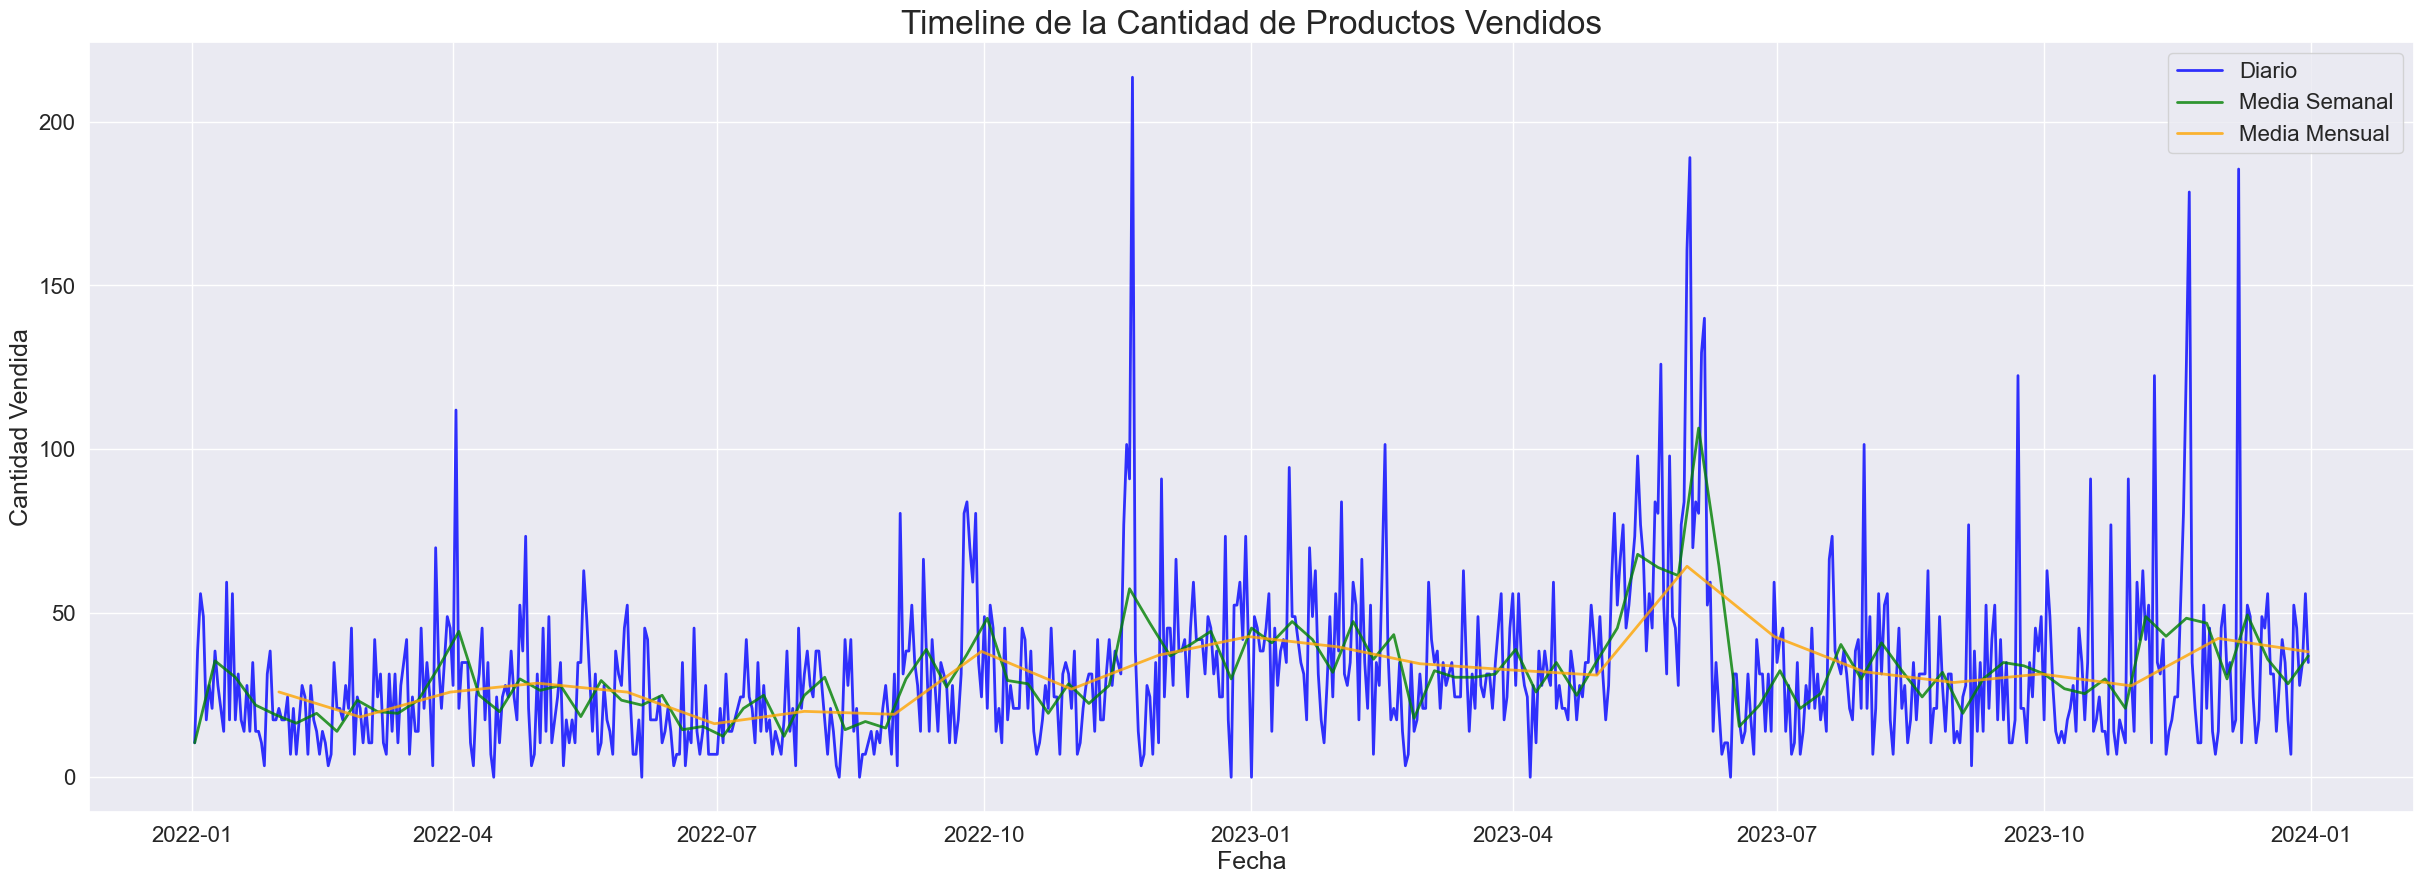

In [74]:
plt.figure(figsize=(30, 10))
sns.set_style("darkgrid")

plt.plot(sales_daily, label='Diario', color='blue', linewidth=2, alpha=0.8)
plt.plot(sales_weekly_mean, label='Media Semanal', color='green', linewidth=2, alpha=0.8)
plt.plot(sales_monthly_mean, label='Media Mensual', color='orange', linewidth=2, alpha=0.8)

plt.title('Timeline de la Cantidad de Productos Vendidos', fontsize=24)
plt.xlabel('Fecha', fontsize=18)
plt.ylabel('Cantidad Vendida', fontsize=18)

plt.legend(fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('Timeline de la Cantidad de Productos Vendidos 0.png', dpi=300, bbox_inches='tight')
plt.show()

In [75]:
sales_monthly = df_final_new.groupby([df_final_new['date'].dt.year.rename('year'), df_final_new['date'].dt.to_period("M").rename('month')])['ctdad'].sum().reset_index()
sales_monthly['month'] = sales_monthly['month'].astype(str)

In [76]:
sales_weekly = df_final_new.groupby([df_final_new['date'].dt.year.rename('year'), df_final_new['date'].dt.to_period("W").rename('week')])['ctdad'].sum().reset_index()
sales_weekly['week'] = sales_weekly['week'].astype(str)

In [77]:
sales_weekly = pd.DataFrame(df_final_new.groupby([df_final_new['date'].dt.year.rename('year'), df_final_new['date'].dt.to_period("W").rename('week')])['ctdad'].sum().reset_index().drop('year', axis=1).set_index('week'))


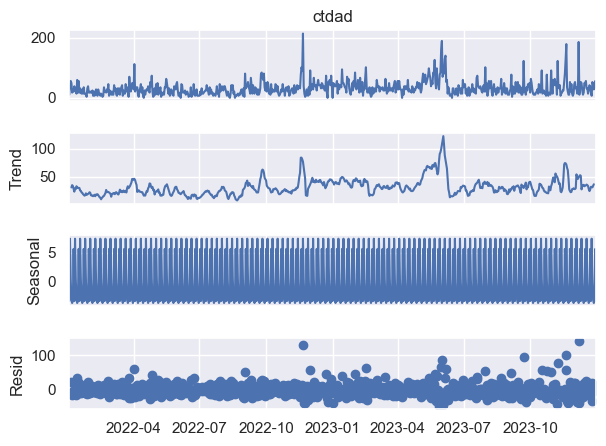

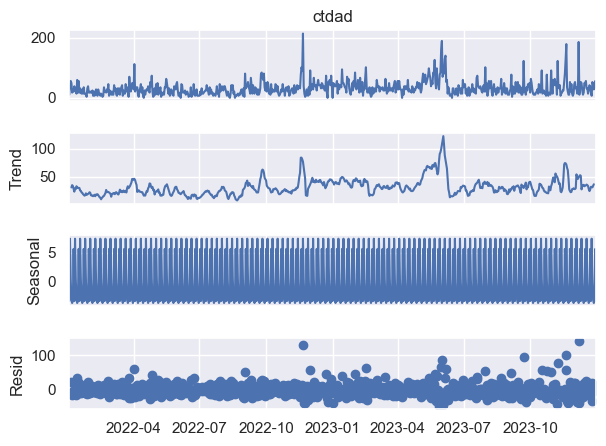

In [78]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_data = seasonal_decompose(sales_daily, model="additive")
decompose_data.plot()

In [79]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(sales_daily, autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -4.304986569382337
2. P-Value :  0.00043546239915550245
3. Num Of Lags :  14
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 714
5. Critical Values :
	 1% :  -3.4395418285955563
	 5% :  -2.865596454500293
	 10% :  -2.5689301318958955


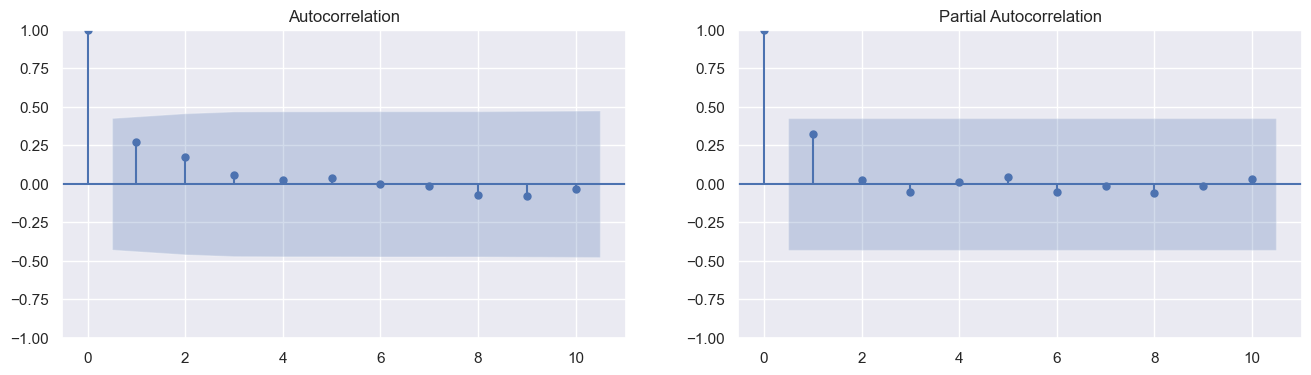

In [80]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

lag_acf = acf(sales_daily, nlags=20)
lag_pacf = pacf(sales_daily, nlags=20, method='ols')

fig, ax = plt.subplots(1,2,figsize=(16,4))
plot_acf(lag_acf, ax=ax[0])
plot_pacf(lag_pacf, ax=ax[1])

plt.savefig('Autocorrelation and Partial Autocorrelation producto 0.png', dpi=300, bbox_inches='tight')
plt.show()

In [81]:
arima_model=auto_arima(sales_weekly_mean, start_p=1,d=1,start_q=1,
                      max_p=5,max_q=5,max_d=5,m=12,
                        start_P=0,D=1,start_Q=0,max_P=5,max_D=5,max_Q=5,
                      seasonal=True,
                       trace=True,
                      error_action="ignore",
                      suppress_warnings=True,
                      stepwise=True,n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=803.516, Time=0.00 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=774.074, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.19 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=800.481, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=763.361, Time=0.14 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=765.028, Time=0.82 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.60 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=761.060, Time=0.17 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=763.054, Time=0.43 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=761.080, Time=0.20 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=0.72 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=766.838, Time=0.11 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=753.854, T

In [82]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  105
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -369.424
Date:                            Thu, 14 Mar 2024   AIC                            748.847
Time:                                    18:24:53   BIC                            761.456
Sample:                                01-02-2022   HQIC                           753.937
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4375      0.166      2.643      0.008       0.113       0.762
ma.L1         -0.9313      0.071    -13.117      0.000      -1.070      -0.792
ar.S.L12      -0.1497      0.196     -0.763      0.446      -0.534       0.235
ma.S.L12      -0.7711      0.250     -3.085      0.002      -1.261      -0.281
sigma2       151.8684     17.062      8.901      0.000     118.427     185.310
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                64.92
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               2.75   Skew:                             0.62
Prob(H) (two-sided):                  0.01   Kurtosis:                         6.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [83]:
month_number = sales_weekly_mean.index.month

# Convierte la serie de números de mes en una variable exógena DataFrame
exog_variable_month = pd.DataFrame(month_number, index=sales_weekly_mean.index)

In [84]:
exog_variables = pd.concat([exog_variable_month], axis=1)

In [85]:
from sklearn.model_selection import train_test_split
size=int(len(sales_weekly_mean)*0.66)
#train_exog, test_exog = train_test_split(exog_variables, test_size = 0.10, shuffle = False)
train_exog,test_exog=exog_variables[0:size],exog_variables[size:len(exog_variables)]

In [86]:
size=int(len(sales_weekly_mean)*0.66)
X_train,X_test=sales_weekly_mean[0:size],sales_weekly_mean[size:len(sales_weekly_mean)]

model=SARIMAX(X_train,
             exog=train_exog,
             order=(1,1,1),
             seasonal_order=(1,1,1,12))
result=model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              ctdad   No. Observations:                   69
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -214.335
Date:                            Thu, 14 Mar 2024   AIC                            440.670
Time:                                    18:24:53   BIC                            452.822
Sample:                                01-02-2022   HQIC                           445.382
                                     - 04-23-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
date          -0.3242      1.059     -0.306      0.759      -2.400       1.751
ar.L1          0.1653      0.267      0.620      0.535      -0.357       0.688
ma.L1         -0.7856      0.196     -4.011      0.000      -1.169      -0.402
ar.S.L12      -0.0438      0.339     -0.129      0.897      -0.709       0.621
ma.S.L12      -0.9990    195.838     -0.005      0.996    -384.835     382.837
sigma2        82.8583   1.62e+04      0.005      0.996   -3.17e+04    3.18e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 3.96
Prob(Q):                              0.84   Prob(JB):                         0.14
Heteroskedasticity (H):               1.12   Skew:                             0.40
Prob(H) (two-sided):                  0.80   Kurtosis:                         4.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [87]:
start_index=0
end_index=len(X_train)-1
train_prediction=result.predict(start_index,end_index, exog = train_exog)

st_index=len(X_train)
ed_index=len(sales_weekly_mean)-1
prediction=result.predict(st_index,ed_index, exog = test_exog)

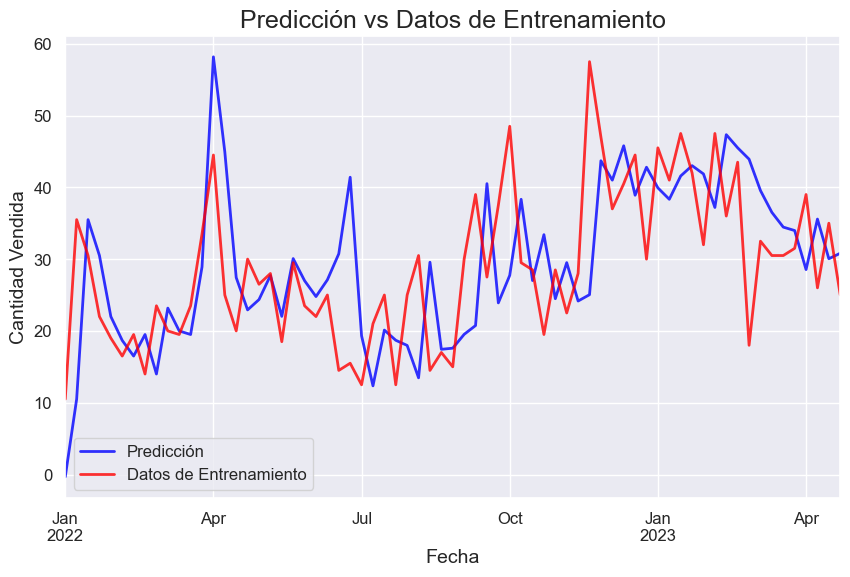

In [88]:
plt.figure(figsize=(10, 6))
sns.set_style("darkgrid")

train_prediction.plot(label='Predicción', color='blue', linewidth=2, alpha=0.8)
X_train.plot(label='Datos de Entrenamiento', color='red', linewidth=2, alpha=0.8)

plt.title('Predicción vs Datos de Entrenamiento', fontsize=18)
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Cantidad Vendida', fontsize=14)

plt.legend(fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('Predicción vs Datos de Entrenamiento 0.png', dpi=300, bbox_inches='tight')
plt.show()

In [89]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Suponiendo que X_test son los valores verdaderos y prediction son los valores predichos

# Calcula el MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(X_train, train_prediction)
print('MAPE:', mape)
print('Mean Absolute Error:', metrics.mean_absolute_error(X_train, train_prediction))
print('MSE:', metrics.mean_squared_error(X_train, train_prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(X_train, train_prediction)))

MAPE: 32.41241668071513
Mean Absolute Error: 8.147438239526844
MSE: 112.85860700045393
RMSE: 10.623493163759928


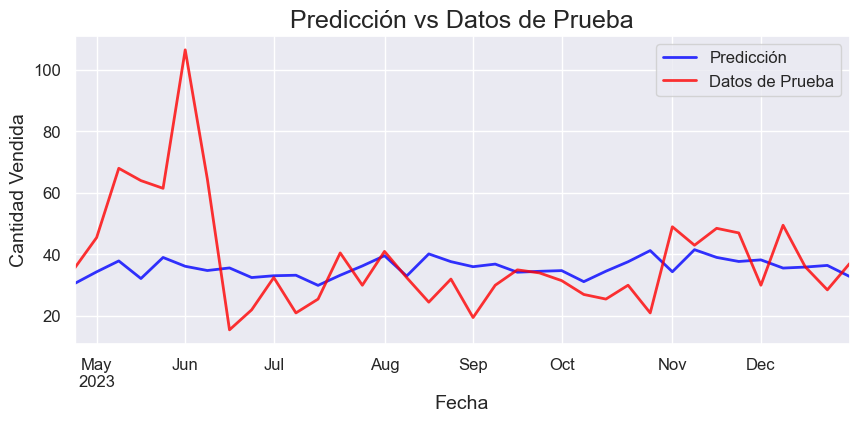

In [90]:
plt.figure(figsize=(10, 4))
sns.set_style("darkgrid")

prediction.plot(label='Predicción', color='blue', linewidth=2, alpha=0.8)
X_test.plot(label='Datos de Prueba', color='red', linewidth=2, alpha=0.8)

plt.title('Predicción vs Datos de Prueba', fontsize=18)
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Cantidad Vendida', fontsize=14)

plt.legend(fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('Predicción vs Datos de Prueba 0.png', dpi=300, bbox_inches='tight')
plt.show()

In [91]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Suponiendo que X_test son los valores verdaderos y prediction son los valores predichos

# Calcula el MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(X_test, prediction)
print('MAPE:', mape)

# Calcula el COD (Coefficient of Determination)
cod = r2_score(X_test, prediction)
# print('COD:', cod)
print('Absolute Error:', metrics.mean_absolute_error(X_test, prediction))
print('MSE:', metrics.mean_squared_error(X_test, prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(X_test, prediction)))

MAPE: 31.213511469580745
Absolute Error: 11.762384855533064
MSE: 308.17560267067694
RMSE: 17.554931007289003


In [92]:
date_range = pd.date_range(start='2024-01-01', periods=92, freq='W')

# Extrae el número de mes de cada fecha en el rango
exog_data = pd.DataFrame({'date': date_range})
exog_data['month'] = exog_data['date'].dt.month

# Asegúrate de que la columna 'date' sea el índice del DataFrame
exog_data.set_index('date', inplace=True)

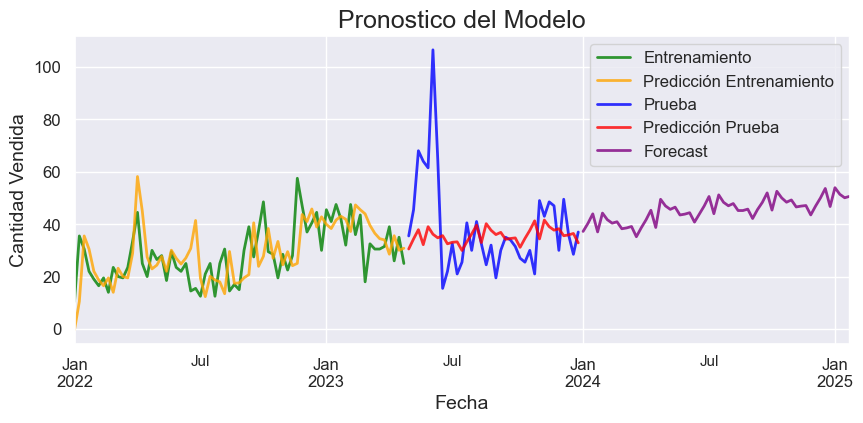

In [93]:
forecast=result.predict(len(sales_weekly_mean), (len(sales_weekly_mean)-1)+56, exog = exog_data).rename('Forecast')

plt.figure(figsize=(10, 4))
sns.set_style("darkgrid")

X_train.plot(label="Entrenamiento", color='green', linewidth=2, alpha=0.8)
train_prediction.plot(label="Predicción Entrenamiento", color='orange', linewidth=2, alpha=0.8)
X_test.plot(label="Prueba", color='blue', linewidth=2, alpha=0.8)
prediction.plot(label="Predicción Prueba", color='red', linewidth=2, alpha=0.8)
forecast.plot(label="Forecast", color="purple", linewidth=2, alpha=0.8)

plt.title('Pronostico del Modelo', fontsize=18)
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Cantidad Vendida', fontsize=14)

plt.legend(fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('Pronostico del Modelo 0.png', dpi=300, bbox_inches='tight')
plt.show()

# Para el producto 1, en todas las regiones

In [94]:
# Para el producto 0, en todas las regiones
df_filtered = df_final[df_final['Encoded Products'] == 1]

df_filtered = df_filtered.sort_values('date')
fecha_min = df_filtered['date'].min()
fecha_max = df_filtered['date'].max()
rango_fechas = pd.date_range(start=fecha_min, end=fecha_max, freq='D')
df_rango_fechas = pd.DataFrame({'date': rango_fechas})

df_final_new = pd.merge(df_rango_fechas, df_filtered, on='date', how='left')
df_final_new['date'] = df_final_new['date'].fillna(method='ffill')
df_final_new.fillna(0, inplace=True)
df_final_new


C:\Users\jesus\AppData\Local\Temp\ipykernel_4568\1054917918.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_final_new['date'] = df_final_new['date'].fillna(method='ffill')


,date,Encoded Products,total,ctdad,Ciudad
0,2022-01-02,1.0,0.000,0.0,Cadereyta
1,2022-01-02,1.0,0.000,0.0,Expos F
2,2022-01-02,1.0,12859.175,7.0,Coahuila
3,2022-01-02,1.0,0.000,0.0,Laredo
4,2022-01-02,1.0,22953.630,14.0,San Luis
...,...,...,...,...,...
6448,2023-12-31,1.0,0.000,0.0,Durango
6449,2023-12-31,1.0,0.000,0.0,Coahuila
6450,2023-12-31,1.0,0.000,0.0,Cadereyta
6451,2023-12-31,1.0,0.000,0.0,Reynosa


In [95]:
df_final_new['date'] = pd.to_datetime(df_final_new['date'])
sales_daily = df_final_new.groupby('date').ctdad.sum()
sales_daily_df = pd.DataFrame(sales_daily)
sales_weekly_mean = sales_daily_df['ctdad'].resample('W').mean()
sales_monthly_mean = sales_daily_df['ctdad'].resample('M').mean()


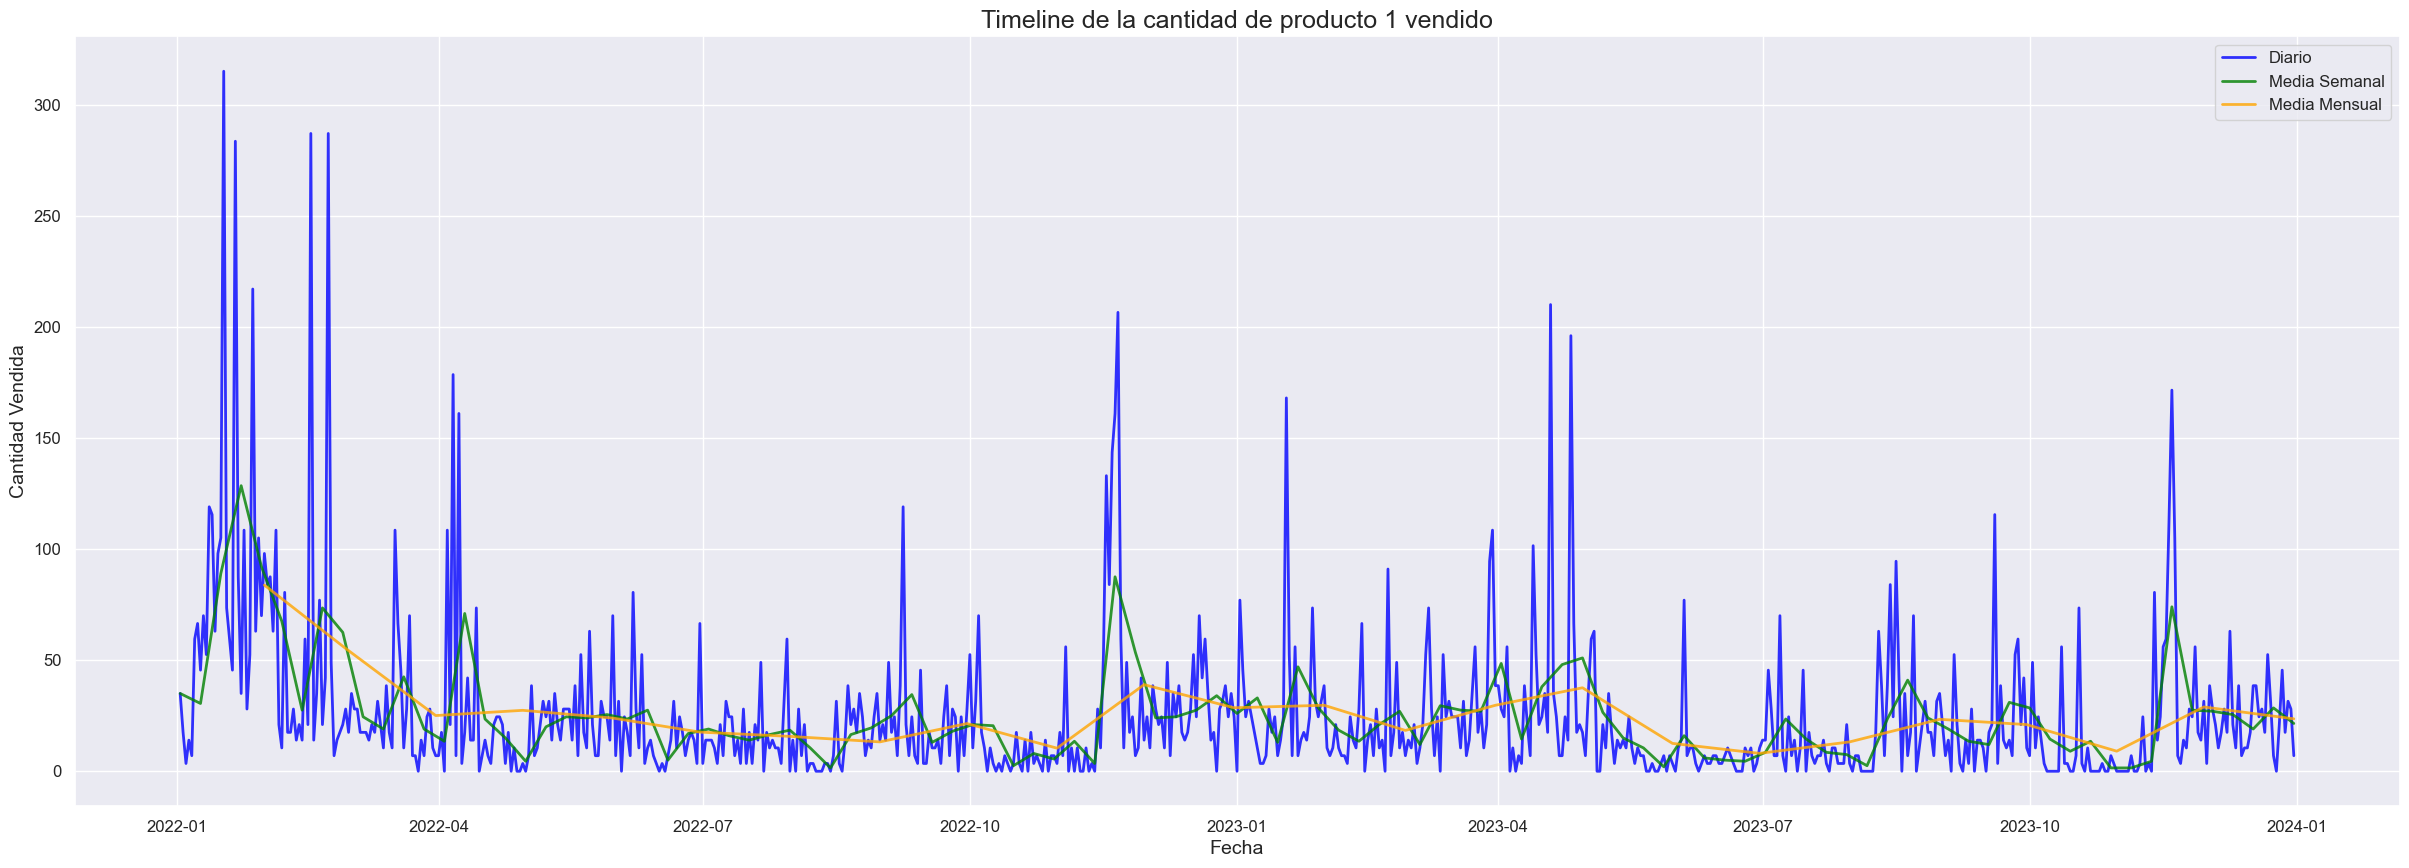

In [96]:
plt.figure(figsize=(30, 10))
sns.set_style("darkgrid")

plt.plot(sales_daily, label='Diario', color='blue', linewidth=2, alpha=0.8)
plt.plot(sales_weekly_mean, label='Media Semanal', color='green', linewidth=2, alpha=0.8)
plt.plot(sales_monthly_mean, label='Media Mensual', color='orange', linewidth=2, alpha=0.8)

plt.title('Timeline de la cantidad de producto 1 vendido', fontsize=18)
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Cantidad Vendida', fontsize=14)

plt.legend(fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('Timeline de la cantidad de producto 1 vendido.png', dpi=300, bbox_inches='tight')
plt.show()


In [97]:

sales_monthly = df_final_new.groupby([df_final_new['date'].dt.year.rename('year'), df_final_new['date'].dt.to_period("M").rename('month')])['ctdad'].sum().reset_index()
sales_monthly['month'] = sales_monthly['month'].astype(str)
sales_weekly = df_final_new.groupby([df_final_new['date'].dt.year.rename('year'), df_final_new['date'].dt.to_period("W").rename('week')])['ctdad'].sum().reset_index()
sales_weekly['week'] = sales_weekly['week'].astype(str)
sales_weekly = pd.DataFrame(df_final_new.groupby([df_final_new['date'].dt.year.rename('year'), df_final_new['date'].dt.to_period("W").rename('week')])['ctdad'].sum().reset_index().drop('year', axis=1).set_index('week'))


1. ADF :  -6.227331487231485
2. P-Value :  5.051223539998069e-08
3. Num Of Lags :  5
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 723
5. Critical Values :
	 1% :  -3.4394269973845657
	 5% :  -2.8655458544300387
	 10% :  -2.568903174551249


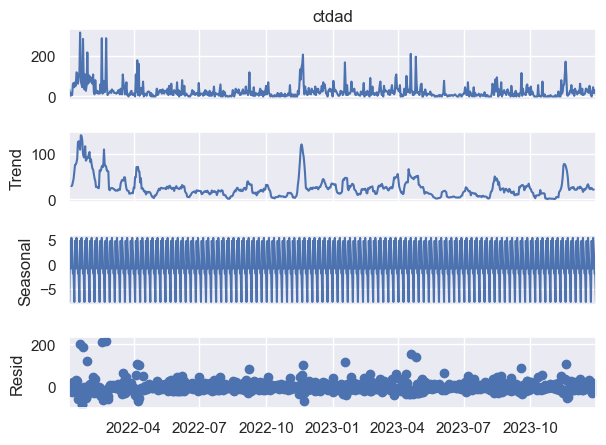

In [98]:

from statsmodels.tsa.seasonal import seasonal_decompose

decompose_data = seasonal_decompose(sales_daily, model="additive")
decompose_data.plot()
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(sales_daily, autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)
    


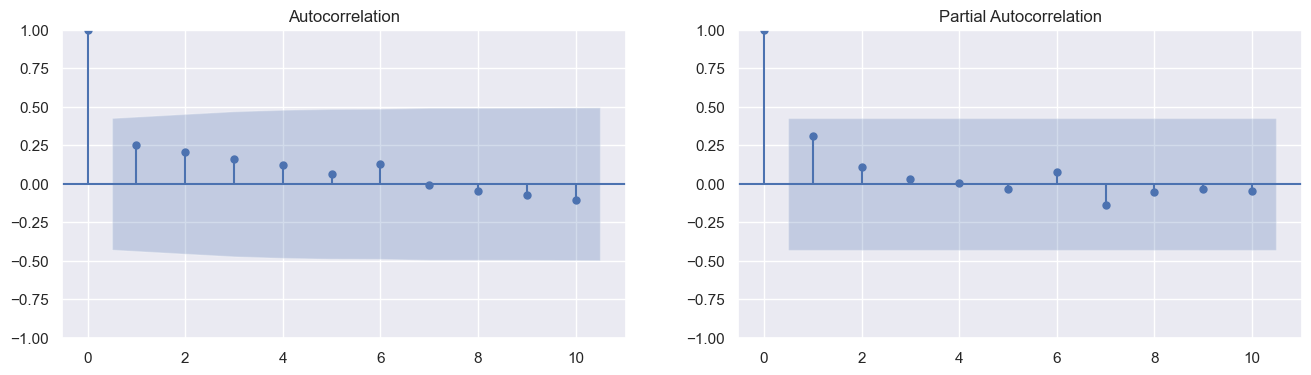

In [99]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

lag_acf = acf(sales_daily, nlags=20)
lag_pacf = pacf(sales_daily, nlags=20, method='ols')

fig, ax = plt.subplots(1,2,figsize=(16,4))
plot_acf(lag_acf, ax=ax[0])
plot_pacf(lag_pacf, ax=ax[1])

plt.savefig('Autocorrelation and Partial Autocorrelation producto 1.png', dpi=300, bbox_inches='tight')
plt.show()


In [100]:

arima_model=auto_arima(sales_weekly_mean, start_p=1,d=1,start_q=1,
                      max_p=5,max_q=5,max_d=5,m=12,
                        start_P=0,D=1,start_Q=0,max_P=5,max_D=5,max_Q=5,
                      seasonal=True,
                       trace=True,
                      error_action="ignore",
                      suppress_warnings=True,
                      stepwise=True,n_fits=50)
arima_model.summary()


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=847.935, Time=0.05 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=872.630, Time=0.00 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=852.179, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=831.486, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=851.051, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.24 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=0.37 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=840.873, Time=0.05 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=0.75 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.21 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=inf, Time=0.23 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.14 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=inf, Time=0.37 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.16 sec

Be

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  105
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -412.743
Date:                            Thu, 14 Mar 2024   AIC                            831.486
Time:                                    18:25:00   BIC                            839.051
Sample:                                01-02-2022   HQIC                           834.539
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6334      0.099     -6.374      0.000      -0.828      -0.439
ma.S.L12      -0.8793      0.264     -3.330      0.001      -1.397      -0.362
sigma2       384.0781     91.473      4.199      0.000     204.794     563.362
===================================================================================
Ljung-Box (L1) (Q):                   2.52   Jarque-Bera (JB):                42.54
Prob(Q):                              0.11   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                             0.62
Prob(H) (two-sided):                  0.09   Kurtosis:                         6.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [101]:

month_number = sales_weekly_mean.index.month

# Convierte la serie de números de mes en una variable exógena DataFrame
exog_variable_month = pd.DataFrame(month_number, index=sales_weekly_mean.index)
exog_variables = pd.concat([exog_variable_month], axis=1)


In [102]:

from sklearn.model_selection import train_test_split
size=int(len(sales_weekly_mean)*0.66)
#train_exog, test_exog = train_test_split(exog_variables, test_size = 0.10, shuffle = False)
train_exog,test_exog=exog_variables[0:size],exog_variables[size:len(exog_variables)]
size=int(len(sales_weekly_mean)*0.66)
X_train,X_test=sales_weekly_mean[0:size],sales_weekly_mean[size:len(sales_weekly_mean)]


In [103]:

model=SARIMAX(X_train,
             exog=train_exog,
             order=(1,1,1),
             seasonal_order=(1,1,1,12))
result=model.fit()
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              ctdad   No. Observations:                   69
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -256.240
Date:                            Thu, 14 Mar 2024   AIC                            524.480
Time:                                    18:25:01   BIC                            536.632
Sample:                                01-02-2022   HQIC                           529.192
                                     - 04-23-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
date          -0.5551      2.579     -0.215      0.830      -5.609       4.499
ar.L1          0.3431      0.402      0.854      0.393      -0.444       1.130
ma.L1         -0.8411      0.217     -3.878      0.000      -1.266      -0.416
ar.S.L12       0.1518      0.586      0.259      0.795      -0.996       1.300
ma.S.L12      -0.9968     66.375     -0.015      0.988    -131.089     129.095
sigma2       396.8817   2.61e+04      0.015      0.988   -5.08e+04    5.16e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                34.46
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.40   Skew:                             0.19
Prob(H) (two-sided):                  0.05   Kurtosis:                         6.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [104]:

start_index=0
end_index=len(X_train)-1
train_prediction=result.predict(start_index,end_index, exog = train_exog)

st_index=len(X_train)
ed_index=len(sales_weekly_mean)-1
prediction=result.predict(st_index,ed_index, exog = test_exog)


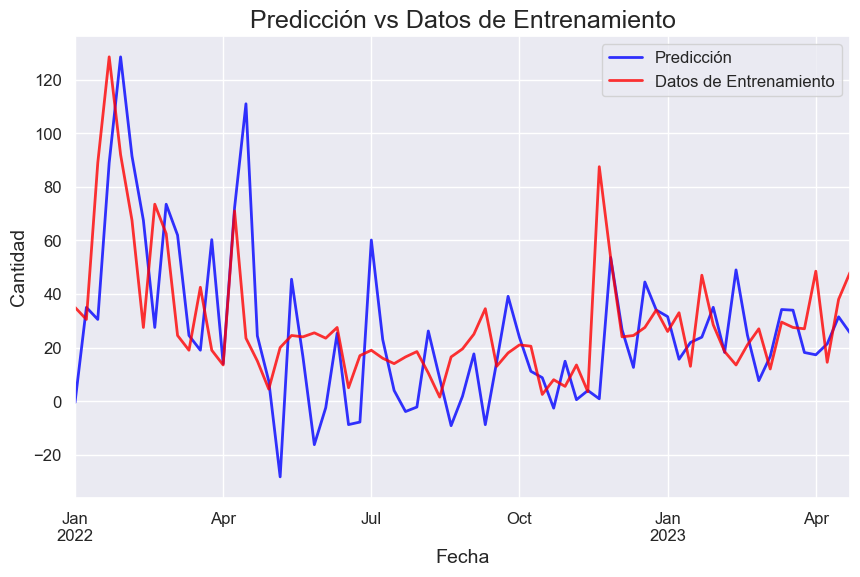

In [105]:
plt.figure(figsize=(10, 6))
sns.set_style("darkgrid")

train_prediction.plot(legend=True, color='blue', linewidth=2, alpha=0.8)
X_train.plot(legend=True, color='red', linewidth=2, alpha=0.8)

plt.title('Predicción vs Datos de Entrenamiento', fontsize=18)
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Cantidad', fontsize=14)

plt.legend(['Predicción', 'Datos de Entrenamiento'], fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('Predicción vs Datos de Entrenamiento 1.png', dpi=300, bbox_inches='tight')
plt.show()


In [106]:

import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Suponiendo que X_test son los valores verdaderos y prediction son los valores predichos

# Calcula el MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(X_train, train_prediction)
print('MAPE:', mape)
print('Mean Absolute Error:', metrics.mean_absolute_error(X_train, train_prediction))
print('MSE:', metrics.mean_squared_error(X_train, train_prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(X_train, train_prediction)))


MAPE: 87.6547701215189
Mean Absolute Error: 18.99465646678107
MSE: 704.8878892050168
RMSE: 26.549724842359794


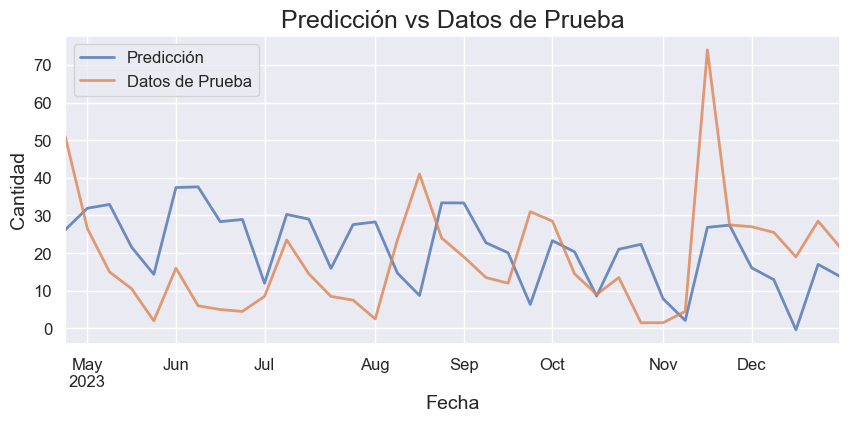

In [107]:

plt.figure(figsize=(10, 4))
sns.set_style("darkgrid")

prediction.plot(legend=True, linewidth=2, alpha=0.8)
X_test.plot(legend=True, linewidth=2, alpha=0.8)

plt.title('Predicción vs Datos de Prueba', fontsize=18)
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Cantidad', fontsize=14)

plt.legend(['Predicción', 'Datos de Prueba'], fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('Predicción vs Datos de Prueba 1.png', dpi=300, bbox_inches='tight')
plt.show()

In [108]:

import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Suponiendo que X_test son los valores verdaderos y prediction son los valores predichos

# Calcula el MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(X_test, prediction)
print('MAPE:', mape)

# Calcula el COD (Coefficient of Determination)
cod = r2_score(X_test, prediction)
# print('COD:', cod)
print('Absolute Error:', metrics.mean_absolute_error(X_test, prediction))
print('MSE:', metrics.mean_squared_error(X_test, prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(X_test, prediction)))


MAPE: 191.69426432818892
Absolute Error: 14.307309685827697
MSE: 307.4593736042256
RMSE: 17.53451948598038


In [109]:

date_range = pd.date_range(start='2024-01-01', periods=92, freq='W')

# Extrae el número de mes de cada fecha en el rango
exog_data = pd.DataFrame({'date': date_range})
exog_data['month'] = exog_data['date'].dt.month


In [110]:

# Asegúrate de que la columna 'date' sea el índice del DataFrame
exog_data.set_index('date', inplace=True)
forecast=result.predict(len(sales_weekly_mean), (len(sales_weekly_mean)-1)+56, exog = exog_data).rename('Forecast')


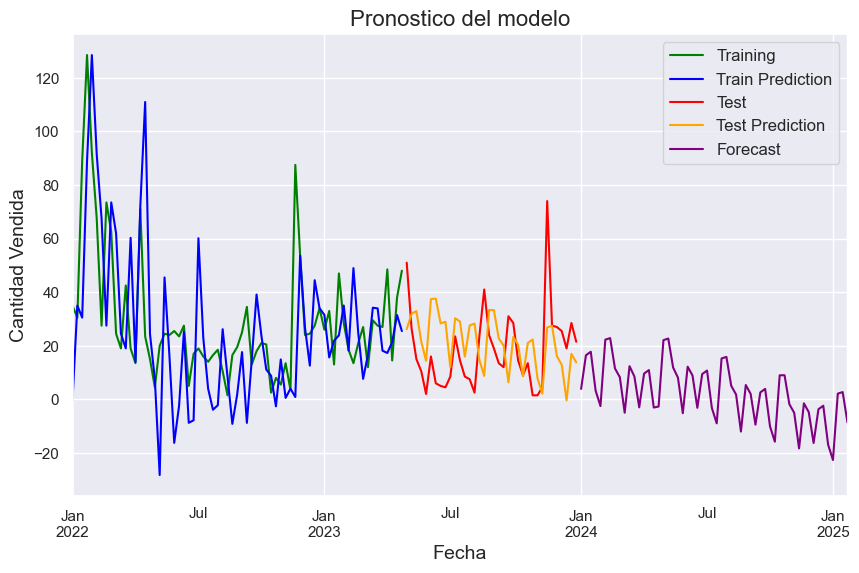

In [111]:
plt.figure(figsize=(10, 6))

X_train.plot(label="Training", color='green')
train_prediction.plot(legend=True, color='blue', label='Train Prediction')
X_test.plot(label="Test", color='red')
prediction.plot(legend=True, color='orange', label='Test Prediction')
forecast.plot(label="Forecast", color="purple")

plt.legend(loc="upper right", fontsize=12)

plt.title('Pronostico del modelo', fontsize=16)
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Cantidad Vendida', fontsize=14)
plt.savefig('Pronostico del modelo 1.png', dpi=300, bbox_inches='tight')
plt.show()